## 3D-VAR Wind Retrieval 

Wind retrieval using a 3D-VAR technique proposed by North et al. (2017). This is a test code for the wind retrieval for an MCS case using KHTX and UAH ARMOR radars.

### Import important functions

In [4]:
%matplotlib inline
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MultipleLocator, ScalarFormatter

from pyart.io import read_grid, write_grid
from pyart.graph import cm

from winds.core import Profile, Solver, Metric
from winds.var import retrieve, common

### Helper functions

In [109]:
def _plot_cappi(
        grid, field, height=0, scale=1.0, cmap=None, norm=None, ticks=None, fig=None, 
        ax=None, alpha=None,  colbar=True):
    """
    """
    
    # Parse figure and axis
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = plt.gca()
    
    # Parse grid coordinates
    x = grid.x['data'] / 1000.0
    y = grid.y['data'] / 1000.0
    z = grid.z['data'] / 1000.0
    
    # Parse grid data
    data = scale * grid.fields[field]['data'][height]
    #datau = scale * grid.fields[fieldu]['data'][height]
    #datav = scale * grid.fields[fieldv]['data'][height]
    
    # Create quadmesh
    qm = ax.pcolormesh(
        x, y, data, cmap=cmap, norm=norm, alpha=alpha, shading='flat', rasterized=True)
    
    #Q = ax.quiver(x[::skipx], y[::skipy], datau[::skipy,::skipx], datav[::skipy,::skipx], units='xy',
    #              scale=5,headwidth=7,headlength=7,width=0.32,pivot='mid')
    #qk = ax.quiverkey(Q, 0.85, 0.53, 20, '20 m/s', labelpos='S',coordinates='figure')
    
    # Create colour bar
    if colbar is True:
        fig.colorbar(mappable=qm, ax=ax, orientation='horizontal', ticks=ticks)
    
    # Set title
    if 'radar_0_instrument_name' in grid.metadata:
        title = '{} {:.1f} km\n{}\n'.format(
            grid.metadata['radar_0_instrument_name'], z[height], field)
    else:
        title = ' {:.1f} km\n{}\n'.format(z[height], field)
    ax.set_title(title)
    
    return

def _plot_cappi_uv(
        grid, fieldu, fieldv, height=0, scale=1.0, fig=None, ax=None, skip_x=1,skip_y=1):
    """
    """
    stormu=16
    stormv=0
    # Parse figure and axis
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = plt.gca()
    
    # Parse grid coordinates
    x = grid.x['data'] / 1000.0
    y = grid.y['data'] / 1000.0
    z = grid.z['data'] / 1000.0
    
    # Parse grid data
    datau = scale * (grid.fields[fieldu]['data'][height]-stormu)
    datav = scale * (grid.fields[fieldv]['data'][height]-stormv)
    keyscale=20
    maskdata =  grid.fields['radar_coverage']['data'][height]
    datau[maskdata<2]=np.nan
    datav[maskdata<2]=np.nan
    # Create quadmesh    
    Q = ax.quiver(x[::skipx], y[::skipy], datau[::skipy,::skipx], datav[::skipy,::skipx], units='xy',
                  scale=5,headwidth=5,headlength=5,width=0.4,pivot='mid')
    qk = ax.quiverkey(Q, 0.85, 0.53, keyscale*scale, str(keyscale)+' m/s', labelpos='S',coordinates='figure')
        
    # Set title
    #if 'radar_0_instrument_name' in grid.metadata:
    #    title = '{} {:.1f} km\n{}\n'.format(
    #        grid.metadata['radar_0_instrument_name'], z[height], field)
    #else:
    #    title = ' {:.1f} km\n{}\n'.format(z[height], field)
    #ax.set_title(title)
    
    return

def _plot_vcappi(
        grid, field, fieldu, fieldv, xslice=-1, yslice=0, scale=1.0, windscale=1.0,cmap=None, norm=None, ticks=None, fig=None, 
        ax=None, alpha=None, colbar=True, skip_x=1,skip_y=1,stormu=0,stormv=0):
    """
    """
    fieldw='vertical_wind_component'
    # Parse figure and axis
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = plt.gca()

    # Parse grid coordinates
    z = grid.z['data'] / 1000.0
    
    # Parse grid data
    mask_field='radar_coverage'
    if xslice < 0:
        data = scale * np.squeeze(grid.fields[field]['data'][:,yslice,:])
        datau = windscale * (np.squeeze(grid.fields[fieldu]['data'][:,yslice,:]-stormu))
        datav = windscale * (np.squeeze(grid.fields[fieldv]['data'][:,yslice,:]-stormv))
        dataw = np.squeeze(grid.fields[fieldw]['data'][:,yslice,:])
        maskdata =  grid.fields['radar_coverage']['data'][:,yslice,:]
        x = grid.x['data'] / 1000.0
        dist=grid.y['data'][yslice]/1000.0
        sliceaxis='y='
    if yslice < 0:
        data = scale * np.squeeze(grid.fields[field]['data'][:,:,xslice])
        datau = windscale * (np.squeeze(grid.fields[fieldu]['data'][:,:,xslice]-stormu))
        datav = windscale * (np.squeeze(grid.fields[fieldv]['data'][:,:,xslice]-stormv))
        dataw =  np.squeeze(grid.fields[fieldw]['data'][:,:,xslice])
        x = grid.y['data'] / 1000.0
        dist=grid.x['data'][xslice]/1000.0
        maskdata =  grid.fields['radar_coverage']['data'][:,:,xslice]
        sliceaxis='x='
    datau[maskdata<2]=np.nan
    datav[maskdata<2]=np.nan
    dataw[maskdata<2]=np.nan
  
    # Create quadmesh
    qm = ax.pcolormesh(
        x, z, data, cmap=cmap, norm=norm, alpha=alpha, shading='flat', rasterized=True)
    #skip=(slice(None,None,8),slice(None,None,8))
    #skipx=12; skipy=4
    Q = ax.quiver(x[::skipx], z[::skipy], datau[::skipy,::skipx], datav[::skipy,::skipx], units='xy',
                  scale=10,headwidth=5,headlength=5,width=0.2,pivot='mid')
    qk = ax.quiverkey(Q, 0.85, 0.52, 40, '{:.1f} m/s'.format(40/windscale), labelpos='S', coordinates='figure')
    ax.contour(x, z, dataw, [2,5,10,20], colors='r')
    ax.contour(x, z, dataw, [-20,-10,-5,-2], colors='b')
    #qk = ax.quiverkey(Q, 0.85, 0.52, 10, '10 m/s', labelpos='W', coordinates='figure',angle=90)
    # Create colour bar
    if colbar is True:
        fig.colorbar(mappable=qm, ax=ax, orientation='vertical', ticks=ticks)
    
    # Set title
    if 'radar_0_instrument_name' in grid.metadata:
        title = '{} {:.1f} km\n{}\n'.format(
            grid.metadata['radar_0_instrument_name'], dist, field)
    else:
        title = '{} {:.1f} km\n{}\n'.format(sliceaxis,dist, field)
    ax.set_title(title)
    
    return
def _plot_vcappiw(
        grid, field, fieldw,  xslice=-1, yslice=0, scale=1.0,cmap=None, norm=None, ticks=None, fig=None, 
        ax=None, alpha=None, colbar=True, skip_x=1,skip_y=1):
    """
    """
    
    # Parse figure and axis
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = plt.gca()

    # Parse grid coordinates
    z = grid.z['data'] / 1000.0
    
    # Parse grid data
    mask_field='radar_coverage'
    if xslice < 0:
        data = scale * np.squeeze(grid.fields[field]['data'][:,yslice,:])
        dataw = scale * np.squeeze(grid.fields[fieldw]['data'][:,yslice,:])
        maskdata =  grid.fields['radar_coverage']['data'][:,yslice,:]
        x = grid.x['data'] / 1000.0
        dist=grid.y['data'][yslice]/1000.0
        sliceaxis='y='
    if yslice < 0:
        data = scale * np.squeeze(grid.fields[field]['data'][:,:,xslice])
        dataw = scale * np.squeeze(grid.fields[fieldw]['data'][:,:,xslice])
        x = grid.y['data'] / 1000.0
        dist=grid.x['data'][xslice]/1000.0
        maskdata =  grid.fields['radar_coverage']['data'][:,:,xslice]
        sliceaxis='x='
    dataw[maskdata<2]=np.nan
 
    # Create quadmesh
    qm = ax.pcolormesh(
        x, z, data, cmap=cmap, norm=norm, alpha=alpha, shading='flat', rasterized=True)
    #skip=(slice(None,None,8),slice(None,None,8))
    #skipx=12; skipy=4
    #Q = ax.quiver(x[::skipx], z[::skipy], datau[::skipy,::skipx], datav[::skipy,::skipx], units='xy',
    #              scale=10,headwidth=5,headlength=5,width=0.2,pivot='mid')
    ax.contour(x, z, dataw, [5,10,20], colors='r')
    ax.contour(x, z, dataw, [-20,-10,-5], colors='b')
    #qk = ax.quiverkey(Q, 0.85, 0.52, 40, '{:.1f} m/s'.format(40/windscale), labelpos='S', coordinates='figure')
    #qk = ax.quiverkey(Q, 0.85, 0.52, 10, '10 m/s', labelpos='W', coordinates='figure',angle=90)
    # Create colour bar
    if colbar is True:
        fig.colorbar(mappable=qm, ax=ax, orientation='vertical', ticks=ticks)
    
    # Set title
    if 'radar_0_instrument_name' in grid.metadata:
        title = '{} {:.1f} km\n{}\n'.format(
            grid.metadata['radar_0_instrument_name'], dist, field)
    else:
        title = '{} {:.1f} km\n{}\n'.format(sliceaxis,dist, field)
    ax.set_title(title)
    
    return

In [36]:
def _plot_conv(
        grid, field, height=0, scale=1.0, cmap=None, norm=None, ticks=None, fig=None, ax=None):
    """
    """
    mask_field='radar_coverage'
    # Parse figure and axis
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = plt.gca()
    
    # Parse grid coordinates
    x = grid.x['data'] / 1000.0
    y = grid.y['data'] / 1000.0
    z = grid.z['data'] / 1000.0
    
    # Parse grid data
    data = scale * grid.fields[field]['data'][height]
    ref =  grid.fields['radar_network_reflectivity']['data'][height]
    maskdata =  grid.fields[mask_field]['data'][height]
    data[maskdata<2]=np.nan
    
    # Create quadmesh
    qm = ax.pcolormesh(
        x, y, data, cmap=cmap, norm=norm, alpha=None, shading='flat', rasterized=True)
    ax.contour(x, y, ref, [30,40,50,60], colors='k')
    
    # Create color bar
    fig.colorbar(mappable=qm, ax=ax, orientation='vertical', ticks=ticks)
    
    # Set title
    if 'radar_0_instrument_name' in grid.metadata:
        title = '{} {:.1f} km\n{}'.format(
            grid.metadata['radar_0_instrument_name'], z[height], field)
    else:
        title = 'N/A {:.1f} km\n{}'.format(z[height], field)
    ax.set_title(title)
    
    return

#### Format color maps

In [6]:
# Define color maps
cmap_refl = cm.NWSRef
cmap_vdop = cm.NWSVel
cmap_gqi = cm.Carbone17
cmap_dist = cm.BlueBrown10
cmap_weight = cm.Carbone17
cmap_uvel = cm.NWSVel
cmap_vvel = cm.NWSVel
cmap_wvel = cm.BuDRd18
cmap_hdiv = cm.BuDRd18
cmap_fall = cm.Carbone42
cmap_cover = cm.LangRainbow12

# Normalize colour maps
norm_refl = BoundaryNorm(np.arange(-10, 65, 5), cmap_refl.N)
norm_vdop = BoundaryNorm(np.arange(-30, 32, 2), cmap_vdop.N)
norm_gqi = BoundaryNorm(np.arange(0, 1.05, 0.05), cmap_gqi.N)
norm_dist = BoundaryNorm(np.arange(0, 2.1, 0.1), cmap_dist.N)
norm_weight = BoundaryNorm(np.arange(0, 1.05, 0.05), cmap_weight.N)
norm_uvel = BoundaryNorm(np.arange(-30, 32, 2), cmap_uvel.N)
norm_vvel = BoundaryNorm(np.arange(-30, 32, 2), cmap_vvel.N)
norm_wvel = BoundaryNorm(np.arange(-8, 8.5, 0.5), cmap_wvel.N)
norm_hdiv = BoundaryNorm(np.arange(-8, 8.5, 0.5), cmap_hdiv.N)
norm_cover = BoundaryNorm(np.arange(0, 5, 1), cmap_cover.N)
norm_fall = BoundaryNorm(np.arange(0, 8.1, 0.1), cmap_fall.N)

# Define colour bar ticks
ticks_refl = np.arange(-10, 70, 10)
ticks_vdop = np.arange(-30, 40, 10)
ticks_gqi = np.arange(0, 1.2, 0.2)
ticks_dist = np.arange(0, 2.4, 0.4)
ticks_weight = np.arange(0, 1.2, 0.2)
ticks_uvel = np.arange(-30, 40, 10)
ticks_vvel = np.arange(-30, 40, 10)
ticks_wvel = np.arange(-8, 10, 2)
ticks_hdiv = np.arange(-8, 10, 2)
ticks_fall = np.arange(0, 9, 1)
ticks_cover = np.arange(0, 5, 1)

### Define grids
Use gridded data. The radar data have to be gridded to a common grid before applying the 3DVAR code. The example gridding notebook is Grid_Radar_ARMOR.ipynb and Grid_Radar_KHTX.ipynb.

In [7]:
# Read grids
#armorfile='/data1/moue/ARMOR/grid/20230401/grid_ARMR20230401071733.nc'
#khtxfile='/data1/moue/nexrad/grid/grid_KHTX20230401_071753_V06.nc'
armorfile='/data1/moue/ARMOR/grid/20230401/grid_ARMR20230401071733.nc'
khtxfile='/data1/moue/nexrad/grid/grid_KHTX20230401_071753_V06.nc'
armor = read_grid(armorfile)
khtx = read_grid(khtxfile)

# List of grids
grids = [armor, khtx]

datetime=armorfile[-17:-3]


### Define solver

In [8]:
solver = Solver(
    grids, constant_resolution=True, method='CG', maxiter=600, gtol=0.1, 
    continuity='Potvin', smoothness='Potvin', impermeability='weak', 
    lambda_o=1.0, lambda_c=500.0, lambda_s1=0.1, lambda_s2=0.1, lambda_s3=0.1, 
    lambda_s4=0.01, lambda_ub=0.01, lambda_vb=0.01, lambda_wb=0.0, vdop_field='corrected_velocity',refl_field='masked_reflectivity',
    lambda_p=1000.0, length_scale=250.0, first_pass=True, maxiter_first_pass=50, 
    finite_order='low', proc=1, debug=False, verbose=True)

x-dimension resolution: 250.00 m
y-dimension resolution: 250.00 m
z-dimension resolution: 250.00 m
Functional size: 18856503
Solver target time: 2023-04-01 07:17:33.055150


In [9]:
print solver.time_target

2023-04-01 07:17:33.055150


In [10]:
print netCDF4.num2date(grids[0].time['data']-1666, grids[0].time['units']).min()
print grids[0].time['units']

2023-04-01 06:49:47.055150
seconds since 2023-04-01T07:17:33Z


#### Grid quality index and nearest neighour weight

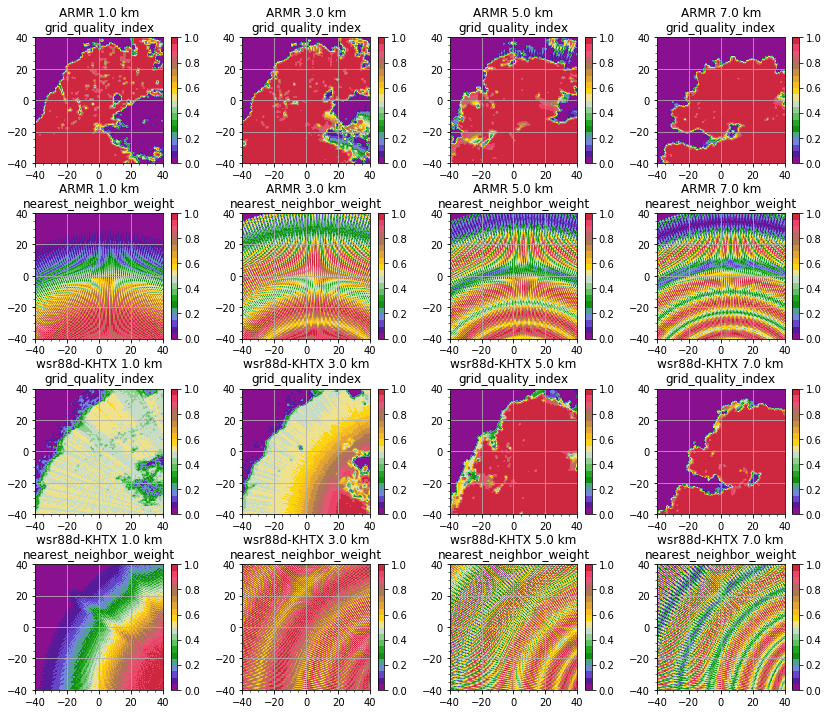

In [11]:
subs = {'xlim': (-40, 40), 'ylim': (-40, 40)}
figs = {'figsize': (14, 12)}
fig, axes = plt.subplots(nrows=4, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

heights = [ 4, 12, 20, 28]

for i, height in enumerate(heights):
    
    # (a) ARMOR grid quality index
    _plot_cappi(armor, 'grid_quality_index', height=height, cmap=cmap_gqi,
                norm=norm_gqi, ticks=ticks_gqi, fig=fig, ax=axes[0,i])
    
    # (b) ARMOR nearest neighbor weight
    _plot_cappi(armor, 'nearest_neighbor_weight', height=height, cmap=cmap_weight, 
                norm=norm_weight, ticks=ticks_weight, fig=fig, ax=axes[1,i])
    
    # (a) KHTX grid quality index
    _plot_cappi(khtx, 'grid_quality_index', height=height, cmap=cmap_gqi,
                norm=norm_gqi, ticks=ticks_gqi, fig=fig, ax=axes[2,i])
    
    # (b) KHTX nearest neighbor weight
    _plot_cappi(khtx, 'nearest_neighbor_weight', height=height, cmap=cmap_weight, 
                norm=norm_weight, ticks=ticks_weight, fig=fig, ax=axes[3,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

#### Compute reflectivity of radar network

In [12]:
# Specify the radar name(s) that we do not want to use the reflectivity. 
# The reflectivity will be used to estimate hydrometeor fall speed.
# This would be useful if the reflectivity can not have good quality (e.g. low resolution, siginificant attenuation)
# the radar name can be found as khtx.metadata['radar_0_instrument_name']
ignore_radars = [
    ]
# merge the radar reflectivity from all radars into one field  
common.add_grid_network_reflectivity(
    grids, solver, ignore_radars=ignore_radars, use_weights=True, 
    debug=True, verbose=True)

Reflectivity observations from grid: ARMR
Min reflectivity weight: 0.000
Max reflectivity weight: 1.000
Reflectivity observations from grid: wsr88d-KHTX
Min reflectivity weight: 0.000
Max reflectivity weight: 1.000
Min network reflectivity: -10.000 dBZ
Max network reflectivity: 55.481 dBZ


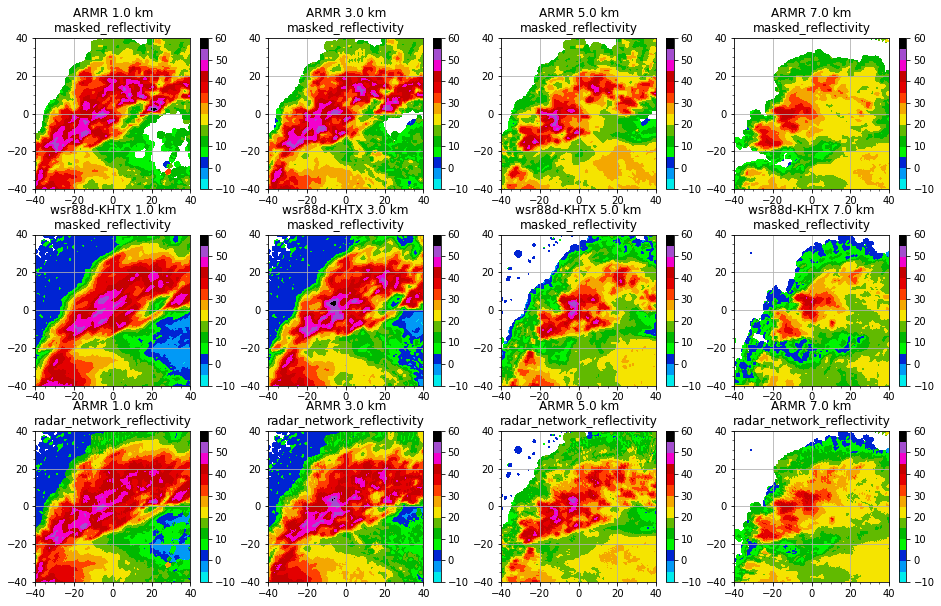

In [13]:
subs = {'xlim': (-40, 40), 'ylim': (-40, 40)}
figs = {'figsize': (16, 10)}
fig, axes = plt.subplots(nrows=3, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.2, hspace=0.3)

heights = [ 4, 12, 20, 28]

for i, height in enumerate(heights):
    
    # (a) ARMOR reflectivity
    _plot_cappi(armor, 'masked_reflectivity', height=height, cmap=cmap_refl,
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) KHTX reflectivity
    _plot_cappi(khtx, 'masked_reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[1,i])
    
    # (d) Network reflectivity
    _plot_cappi(armor, 'radar_network_reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[2,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

### Atmospheric profile data 

Use sounding data to define atmospheric profiles. 
Use one of the following method based on the sonde data availability. 
If ARM sonde data is available, it will be great. If not, use NWS sonde text data dounloaded from the U. Wyoming site.

##### 1) Read NWS text data from U. Wyoming 

In [14]:
# 1) Read NWS text data from U. Wyoming 
#sndfile='/data1/moue/sounding/asc/BMX_2021121112z.txt'
sndfile='/data1/moue/sounding/asc/BMX_2023040106z.txt'
pres_sonde,alt_sonde,tdry_sonde,dp_sonde,rh_sonde,wdir_sonde,wspdkt_sonde=np.loadtxt(sndfile, converters=None, skiprows=4, usecols=(0,1,2,3,4,6,7), unpack=True)
wspd_sonde=wspdkt_sonde * 0.514444444; #kt -> m/s
rad_th = (wdir_sonde-180) / 180 * 3.1415926;
u_sonde = wspd_sonde * np.sin(rad_th);
v_sonde = wspd_sonde * np.cos(rad_th);
pres_sonde = pres_sonde / 10 #hPa -> kPa 
rho_d_sonde = (pres_sonde * 1000.0) / (287.058 * (tdry_sonde + 273.15)) # Dry air density
w_sonde = np.zeros_like(tdry_sonde, subok=False) #dummy w



##### 2) Read ARM sonde data

In [ ]:
#2) Read ARM sonde data
#sndfile='/data1/moue/hou/sonde/housondewnpnM1.b1.20220611.173000.cdf'
#sonde=netCDF4.Dataset(sndfile,'r')
#pres_sonde=sonde.variables['pres'][:] #hPa
#tdry_sonde=sonde.variables['tdry'][:] #C
#alt_sonde=sonde.variables['alt'][:] #m
#wspd_sonde=sonde.variables['wspd'][:] #m/s 
#wdir_sonde=sonde.variables['deg'][:] #degrees
#u_sonde=sonde.variables['u_wind'][:]
#v_sonde=sonde.variables['v_wind'][:]
#rh_sonde=sonde.variables['rh'][:]
#dp_sonde=sonde.variables['dp'][:]
#pres_sonde = pres_sonde / 10 #hPa -> kPa 
#rho_d_sonde = (pres_sonde * 1000.0) / (287.058 * (tdry_sonde + 273.15)) # Dry air density
#w_sonde = np.zeros_like(tdry_sonde, subok=False) #dummy w


##### 3) Read ARM mergesonde data

In [ ]:
#3) Read ARM mergesonde data
#sndfile = '/data1/moue/kirk_data/MC3E/sounding_data/sgpmergesonde1maceC1.c1.20110520.000000.cdf'
#sonde = netCDF4.Dataset(sndfile, mode='r')

# Create profile
#profile = common.arm_mergesonde_profile(
#    solver, sonde, rate_method='cubic', debug=True, verbose=True)


#### Estimate vapor pressure (Flatau et al. 1992 (hPa)) and Interpolate to create sonde profiles for the vertical grid spacing
This is not needed if the ARM mergesonde data is used (if select 3) above).

In [15]:
##= Estimate vapor pressure : Flatau et al. 1992 (hPa)
Etrp = 6.11;
Rvap = 0.110;
Cp = 0.240;
exp = 2.7182818;
a1 = 6.11583699;            b1 = 6.09868993;
a2 = 0.444606896;           b2 = 0.499320233;
a3 = 0.143177157e-1;        b3 = 0.184672631e-1;
a4 = 0.264224321e-3;        b4 = 0.402737184e-3;
a5 = 0.299291018e-5;        b5 = 0.565392987e-5;
a6 = 0.203154182e-7;        b6 = 0.521693933e-7;
a7 = 0.702620698e-10;       b7 = 0.307839583e-9;
a8 = 0.379534310e-13;       b8 = 0.105785160e-11;
a9 = -0.321582393e-15;      b9 = 0.161444444e-14;
nt,=tdry_sonde.shape
es_sonde=np.zeros((nt))
for i in range(0,nt):
    T = tdry_sonde[i];
    es_sonde[i] = (a1+T*(a2+T*(a3+T*(a4+T*(a5+T*(a6+T*(a7+T*(a8+T*a9))))))));

xe  = rh_sonde / 100.0 * (es_sonde);  #vapor pressure [hPa]
xqs  = 0.622 * (es_sonde) / ( (pres_sonde*10) -  es_sonde ); #saturated mixing ratio
xq   = 0.622 * xe  / ( (pres_sonde*10)-  xe  ); #mixing ratio

mr_sonde = xq;
sh_sonde = mr_sonde / (1.0+mr_sonde); #specific humidity [kg/kg]
es_sonde = es_sonde/10 #hPa -> kPa

##= Interpolation
from scipy.interpolate import UnivariateSpline
alt_grid = solver.z + solver.alt_0
tdry = UnivariateSpline(alt_sonde, tdry_sonde).__call__(alt_grid)
dp = UnivariateSpline(alt_sonde, dp_sonde).__call__(alt_grid)
pres = UnivariateSpline(alt_sonde, pres_sonde).__call__(alt_grid)
es = UnivariateSpline(alt_sonde, es_sonde).__call__(alt_grid) #vapor pressure
rho_d = UnivariateSpline(alt_sonde, rho_d_sonde).__call__(alt_grid)
rh = UnivariateSpline(alt_sonde, rh_sonde).__call__(alt_grid)
sh = UnivariateSpline(alt_sonde, sh_sonde).__call__(alt_grid)
wspd = UnivariateSpline(alt_sonde, wspd_sonde).__call__(alt_grid)
wdir = UnivariateSpline(alt_sonde, wdir_sonde).__call__(alt_grid)
u = UnivariateSpline(alt_sonde, u_sonde).__call__(alt_grid)
v = UnivariateSpline(alt_sonde, v_sonde).__call__(alt_grid)
w = UnivariateSpline(alt_sonde, w_sonde).__call__(alt_grid)

##= Create profile
profile =Profile(alt=alt_grid, tdry=tdry, dp=dp, pres=pres, rho=rho_d,
                 wspd=wspd, wdir=wdir, u=u, v=v, w=w,
                 rh=rh, sh=sh, e=es, cs=None, rate_method='cubic')


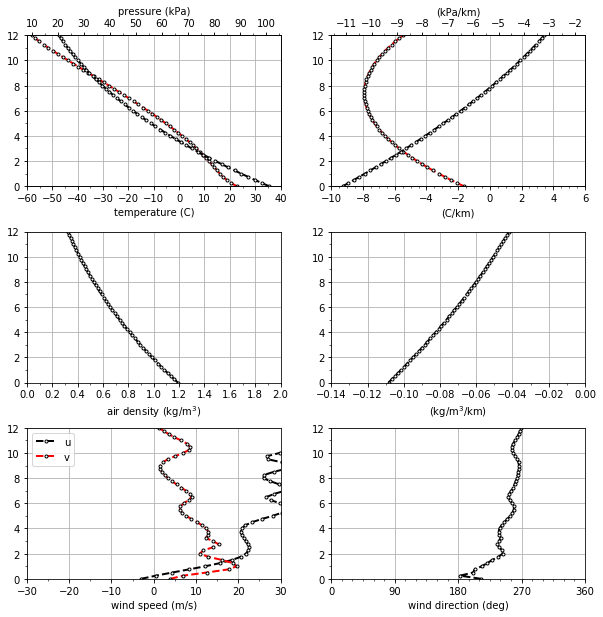

In [16]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(wspace=0.2, hspace=0.3)

# (a-b) Temperature and pressure with height
axa = fig.add_subplot(321, xlim=(-60, 40), ylim=(0, 12))
axa.plot(profile.tdry, profile.alt / 1000.0, 'r--', lw=2, marker='o', 
         ms=3, mfc='w', mec='k')
axa.xaxis.set_major_locator(MultipleLocator(10))
axa.xaxis.set_minor_locator(MultipleLocator(5))
axa.yaxis.set_major_locator(MultipleLocator(2))
axa.yaxis.set_minor_locator(MultipleLocator(1))
axa.set_xlabel('temperature (C)')
axa.grid(which='major')
axb = axa.twiny()
axb.plot(profile.pres, profile.alt / 1000.0, 'k--', lw=2, marker='o', 
         ms=3, mfc='w', mec='k')
axb.xaxis.set_major_locator(MultipleLocator(10))
axb.xaxis.set_minor_locator(MultipleLocator(5))
axb.set_xlabel('pressure (kPa)')

# (c-d) Temperature and pressure rates of change
axc = fig.add_subplot(322, xlim=(-10, 6), ylim=(0, 12))
axc.plot(profile.dtdrydz * 1000.0, profile.alt / 1000.0, 'r--', lw=2, 
         marker='o', ms=3, mfc='w', mec='k')
axc.xaxis.set_major_locator(MultipleLocator(2))
axc.xaxis.set_minor_locator(MultipleLocator(0.5))
axc.yaxis.set_major_locator(MultipleLocator(2))
axc.yaxis.set_minor_locator(MultipleLocator(1))
axc.set_xlabel('(C/km)')
axc.grid(which='major')
axd = axc.twiny()
axd.plot(profile.dpresdz * 1000.0, profile.alt / 1000.0, 'k--', lw=2, 
         marker='o', ms=3, mfc='w', mec='k')
axd.xaxis.set_major_locator(MultipleLocator(1))
axd.xaxis.set_minor_locator(MultipleLocator(0.5))
axd.set_xlabel('(kPa/km)')

# (e) Air density
axe = fig.add_subplot(323, xlim=(0, 2), ylim=(0, 12))
axe.plot(profile.rho, profile.alt / 1000.0, 'k--', lw=2, marker='o', 
         ms=3, mfc='w', mec='k')
axe.xaxis.set_major_locator(MultipleLocator(0.2))
axe.xaxis.set_minor_locator(MultipleLocator(0.1))
axe.yaxis.set_major_locator(MultipleLocator(2))
axe.yaxis.set_minor_locator(MultipleLocator(1))
axe.set_xlabel('air density (kg/m$^3$)')
axe.grid(which='major')

# (f) Air density rate of change
axf = fig.add_subplot(324, xlim=(-0.14, 0), ylim=(0, 12))
axf.plot(profile.drhodz * 1000.0, profile.alt / 1000.0, 'k--', lw=2, 
         marker='o', ms=3, mfc='w', mec='k')
axf.xaxis.set_major_locator(MultipleLocator(0.02))
axf.xaxis.set_minor_locator(MultipleLocator(0.01))
axf.yaxis.set_major_locator(MultipleLocator(2))
axf.yaxis.set_minor_locator(MultipleLocator(1))
axf.set_xlabel('(kg/m$^3$/km)')
axf.grid(which='major')

# (g) Wind speed
axg = fig.add_subplot(325, xlim=(-30, 30), ylim=(0, 12))
axg.plot(profile.u, profile.alt / 1000.0, 'k--', lw=2, marker='o', 
         ms=3, mfc='w', mec='k', label='u')
axg.plot(profile.v, profile.alt / 1000.0, 'r--', lw=2, marker='o', 
         ms=3, mfc='w', mec='k', label='v')
axg.xaxis.set_major_locator(MultipleLocator(10))
axg.xaxis.set_minor_locator(MultipleLocator(5))
axg.yaxis.set_major_locator(MultipleLocator(2))
axg.yaxis.set_minor_locator(MultipleLocator(1))
axg.set_xlabel('wind speed (m/s)')
axg.grid(which='major')
axg.legend(loc='upper left')

# (h) Wind direction
axh = fig.add_subplot(326, xlim=(0, 360), ylim=(0, 12))
axh.plot(profile.wdir, profile.alt / 1000.0, 'k--', lw=2, marker='o', 
         ms=3, mfc='w', mec='k')
axh.xaxis.set_major_locator(MultipleLocator(90))
axh.xaxis.set_minor_locator(MultipleLocator(15))
axh.yaxis.set_major_locator(MultipleLocator(2))
axh.yaxis.set_minor_locator(MultipleLocator(1))
axh.set_xlabel('wind direction (deg)')
axh.grid(which='major')

#### Hydrometeor fall speed

In [17]:
common.add_fall_speed_caya(grids, solver, profile=profile, debug=True, verbose=True)

Min hydrometeor fall speed: 0.000 m/s
Max hydrometeor fall speed: 8.756 m/s


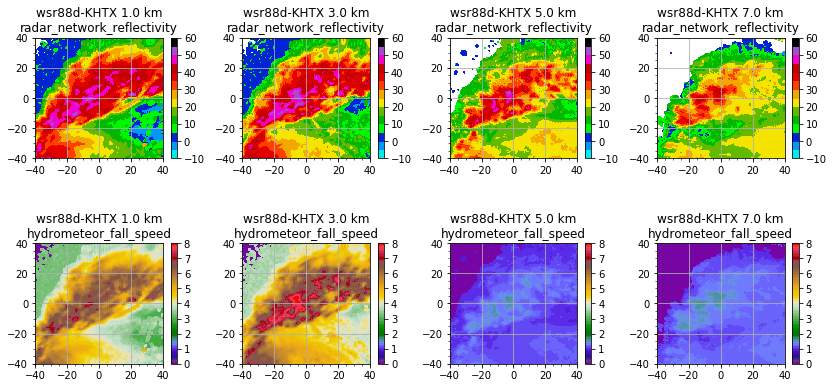

In [18]:
subs = {'xlim': (-40, 40), 'ylim': (-40, 40)}
figs = {'figsize': (14, 6)}
fig, axes = plt.subplots(nrows=2, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.3, hspace=0.7)

heights = [4, 12, 20, 28]

for i, height in enumerate(heights):
    
    # (a) Network reflectivity
    _plot_cappi(khtx, 'radar_network_reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Hydrometeor fall speed
    _plot_cappi(khtx, 'hydrometeor_fall_speed', height=height, cmap=cmap_fall, 
                norm=norm_fall, ticks=ticks_fall, fig=fig, ax=axes[1,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

#### Radar velocity observation weights

In [19]:
common.add_grid_radial_velocity_weight(
    grids, solver, use_weights=True, debug=True, verbose=True)

Radial velocities from grid: ARMR
Weighting radial velocity:  nearest_neighbor_weight
Min radial velocity weight: 0.000
Max radial velocity weight: 1.000
Radial velocities from grid: wsr88d-KHTX
Weighting radial velocity:  nearest_neighbor_weight
Min radial velocity weight: 0.000
Max radial velocity weight: 1.000


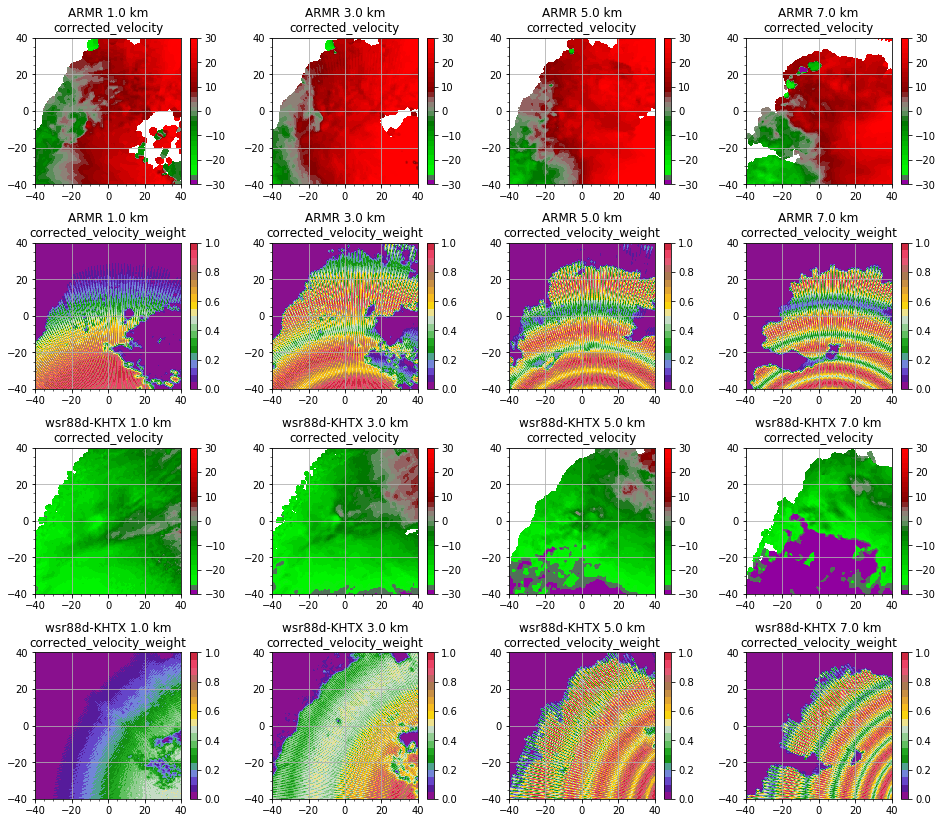

In [20]:
subs = {'xlim': (-40, 40), 'ylim': (-40, 40)}
figs = {'figsize': (16, 14)}
fig, axes = plt.subplots(nrows=4, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

heights = [4, 12, 20, 28]

for i, height in enumerate(heights):
    
    # (a) ARMOR radial velocity
    _plot_cappi(armor, 'corrected_velocity', height=height, cmap=cmap_vdop,
                norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[0,i])
    
    # (b) ARMOR radial velocity weight
    _plot_cappi(armor, 'corrected_velocity_weight', height=height, cmap=cmap_weight, 
                norm=norm_weight, ticks=ticks_weight, fig=fig, ax=axes[1,i])
 
    # (a) KHTX radial velocity
    _plot_cappi(khtx, 'corrected_velocity', height=height, cmap=cmap_vdop,
                norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[2,i])
    
    #(b) KHTX radial velocity weight
    _plot_cappi(khtx, 'corrected_velocity_weight', height=height, cmap=cmap_weight, 
                norm=norm_weight, ticks=ticks_weight, fig=fig, ax=axes[3,i])
    

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

#### Radar coverage

In [21]:
common.add_grid_coverage(grids, solver, atol=0.01, debug=True, verbose=True)

Coverage by grid: ARMR
Coverage by grid: wsr88d-KHTX
Min radar coverage: 0
Max radar coverage: 2


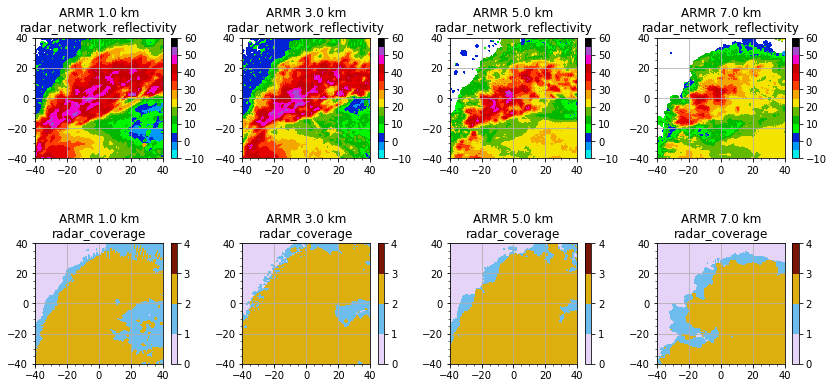

In [22]:
subs = {'xlim': (-40, 40), 'ylim': (-40, 40)}
figs = {'figsize': (14, 6)}
fig, axes = plt.subplots(nrows=2, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.3, hspace=0.7)

heights = [4, 12, 20, 28]

for i, height in enumerate(heights):
    
    # (a) Network reflectivity
    _plot_cappi(armor, 'radar_network_reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Radar coverage
    _plot_cappi(armor, 'radar_coverage', height=height, cmap=cmap_cover, 
                norm=norm_cover, ticks=ticks_cover, fig=fig, ax=axes[1,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

#### Multi-Doppler wind retrieval

In [23]:
conv = retrieve.solve_wind_field(
    grids, solver=solver, profile=profile, background='profile', first_guess='zero',
    fall_speed='Caya', legacy=True, debug=True, verbose=True)

Number of input grids: 2
Line-of-sight components for grid: ARMR
Radar x offset in grid: 6.743 km
Radar y offset in grid: -78.748 km
Radar z offset in grid: 0.224 km
Line-of-sight components for grid: wsr88d-KHTX
Radar x offset in grid: 69.566 km
Radar y offset in grid: -46.933 km
Radar z offset in grid: 0.566 km
Min hydrometeor fall speed: 0.000 m/s
Max hydrometeor fall speed: 8.756 m/s
Performing heavily-smoothed first pass
Gradient iteration: 1
Magnitude of gradient: 2.70272e+04
Cost iteration: 1
Radial velocity observation cost : 6.55007e+08
Mass continuity cost ........... : 0.00000e+00
Smoothness cost ................ : 0.00000e+00
Background field cost .......... : 3.81078e+07
Surface impermeability cost .... : 0.00000e+00
Total cost ..................... : 6.93114e+08
Cost iteration: 2
Radial velocity observation cost : 6.54980e+08
Mass continuity cost ........... : 0.00000e+00
Smoothness cost ................ : 8.36534e-01
Background field cost .......... : 3.81074e+07
Surface

Magnitude of gradient: 1.02204e+05
Cost iteration: 23
Radial velocity observation cost : 2.09477e+08
Mass continuity cost ........... : 0.00000e+00
Smoothness cost ................ : 8.78653e+07
Background field cost .......... : 3.08981e+07
Surface impermeability cost .... : 4.83955e+06
Total cost ..................... : 3.33080e+08
Gradient iteration: 23
Magnitude of gradient: 1.47539e+05
Cost iteration: 24
Radial velocity observation cost : 2.11412e+08
Mass continuity cost ........... : 0.00000e+00
Smoothness cost ................ : 8.64719e+07
Background field cost .......... : 3.09555e+07
Surface impermeability cost .... : 6.80704e+05
Total cost ..................... : 3.29520e+08
Gradient iteration: 24
Magnitude of gradient: 8.44738e+04
Cost iteration: 25
Radial velocity observation cost : 2.08005e+08
Mass continuity cost ........... : 0.00000e+00
Smoothness cost ................ : 7.44579e+07
Background field cost .......... : 3.08448e+07
Surface impermeability cost .... : 6.412

Magnitude of gradient: 1.11802e+05
Cost iteration: 46
Radial velocity observation cost : 1.82568e+08
Mass continuity cost ........... : 0.00000e+00
Smoothness cost ................ : 2.20197e+07
Background field cost .......... : 2.98152e+07
Surface impermeability cost .... : 9.80769e+05
Total cost ..................... : 2.35384e+08
Gradient iteration: 46
Magnitude of gradient: 5.91881e+04
Cost iteration: 47
Radial velocity observation cost : 1.79719e+08
Mass continuity cost ........... : 0.00000e+00
Smoothness cost ................ : 2.16765e+07
Background field cost .......... : 2.96847e+07
Surface impermeability cost .... : 3.43775e+05
Total cost ..................... : 2.31424e+08
Gradient iteration: 47
Magnitude of gradient: 5.21841e+04
Cost iteration: 48
Radial velocity observation cost : 1.78767e+08
Mass continuity cost ........... : 0.00000e+00
Smoothness cost ................ : 1.90538e+07
Background field cost .......... : 2.96418e+07
Surface impermeability cost .... : 1.933

Magnitude of gradient: 6.51961e+04
Cost iteration: 69
Radial velocity observation cost : 1.44229e+08
Mass continuity cost ........... : 0.00000e+00
Smoothness cost ................ : 1.66260e+07
Background field cost .......... : 2.83624e+07
Surface impermeability cost .... : 1.08270e+06
Total cost ..................... : 1.90300e+08
Gradient iteration: 69
Magnitude of gradient: 6.41732e+04
Cost iteration: 70
Radial velocity observation cost : 1.39233e+08
Mass continuity cost ........... : 0.00000e+00
Smoothness cost ................ : 1.69759e+07
Background field cost .......... : 2.81952e+07
Surface impermeability cost .... : 1.34787e+06
Total cost ..................... : 1.85752e+08
Gradient iteration: 70
Magnitude of gradient: 6.93290e+04
Cost iteration: 71
Radial velocity observation cost : 1.37314e+08
Mass continuity cost ........... : 0.00000e+00
Smoothness cost ................ : 1.55583e+07
Background field cost .......... : 2.81329e+07
Surface impermeability cost .... : 1.057

Magnitude of gradient: 2.51720e+05
Cost iteration: 6
Radial velocity observation cost : 1.27714e+08
Mass continuity cost ........... : 3.44913e+08
Smoothness cost ................ : 9.05983e+04
Background field cost .......... : 2.77896e+07
Surface impermeability cost .... : 1.30246e+06
Total cost ..................... : 5.01809e+08
Gradient iteration: 6
Magnitude of gradient: 2.30830e+05
Cost iteration: 7
Radial velocity observation cost : 1.27982e+08
Mass continuity cost ........... : 3.06592e+08
Smoothness cost ................ : 1.12604e+05
Background field cost .......... : 2.77755e+07
Surface impermeability cost .... : 6.51039e+06
Total cost ..................... : 4.68972e+08
Gradient iteration: 7
Magnitude of gradient: 3.83812e+05
Cost iteration: 8
Radial velocity observation cost : 1.28683e+08
Mass continuity cost ........... : 1.80474e+08
Smoothness cost ................ : 9.24351e+04
Background field cost .......... : 2.77412e+07
Surface impermeability cost .... : 1.56090e+0

Magnitude of gradient: 6.98319e+04
Cost iteration: 29
Radial velocity observation cost : 1.27918e+08
Mass continuity cost ........... : 2.65998e+07
Smoothness cost ................ : 9.14936e+04
Background field cost .......... : 2.75604e+07
Surface impermeability cost .... : 4.03237e+05
Total cost ..................... : 1.82573e+08
Gradient iteration: 29
Magnitude of gradient: 1.10337e+05
Cost iteration: 30
Radial velocity observation cost : 1.28021e+08
Mass continuity cost ........... : 2.60393e+07
Smoothness cost ................ : 9.03540e+04
Background field cost .......... : 2.75658e+07
Surface impermeability cost .... : 2.62300e+05
Total cost ..................... : 1.81979e+08
Gradient iteration: 30
Magnitude of gradient: 6.80179e+04
Cost iteration: 31
Radial velocity observation cost : 1.27795e+08
Mass continuity cost ........... : 2.34401e+07
Smoothness cost ................ : 9.10500e+04
Background field cost .......... : 2.75543e+07
Surface impermeability cost .... : 3.266

Magnitude of gradient: 3.92390e+04
Cost iteration: 52
Radial velocity observation cost : 1.20748e+08
Mass continuity cost ........... : 9.44194e+06
Smoothness cost ................ : 1.30018e+05
Background field cost .......... : 2.72980e+07
Surface impermeability cost .... : 2.55541e+05
Total cost ..................... : 1.57874e+08
Gradient iteration: 52
Magnitude of gradient: 8.45546e+04
Cost iteration: 53
Radial velocity observation cost : 1.20936e+08
Mass continuity cost ........... : 8.54005e+06
Smoothness cost ................ : 1.28661e+05
Background field cost .......... : 2.73039e+07
Surface impermeability cost .... : 1.37361e+05
Total cost ..................... : 1.57046e+08
Gradient iteration: 53
Magnitude of gradient: 3.35470e+04
Cost iteration: 54
Radial velocity observation cost : 1.20588e+08
Mass continuity cost ........... : 8.32444e+06
Smoothness cost ................ : 1.30811e+05
Background field cost .......... : 2.72931e+07
Surface impermeability cost .... : 1.358

Magnitude of gradient: 4.95780e+04
Cost iteration: 75
Radial velocity observation cost : 1.11669e+08
Mass continuity cost ........... : 6.83192e+06
Smoothness cost ................ : 1.96089e+05
Background field cost .......... : 2.70291e+07
Surface impermeability cost .... : 1.27107e+05
Total cost ..................... : 1.45853e+08
Gradient iteration: 75
Magnitude of gradient: 8.10039e+04
Cost iteration: 76
Radial velocity observation cost : 1.11868e+08
Mass continuity cost ........... : 5.77944e+06
Smoothness cost ................ : 1.93637e+05
Background field cost .......... : 2.70354e+07
Surface impermeability cost .... : 9.12859e+04
Total cost ..................... : 1.44968e+08
Gradient iteration: 76
Magnitude of gradient: 3.03952e+04
Cost iteration: 77
Radial velocity observation cost : 1.11577e+08
Mass continuity cost ........... : 5.33870e+06
Smoothness cost ................ : 1.95778e+05
Background field cost .......... : 2.70263e+07
Surface impermeability cost .... : 1.305

Magnitude of gradient: 4.58733e+04
Cost iteration: 98
Radial velocity observation cost : 1.07904e+08
Mass continuity cost ........... : 3.58283e+06
Smoothness cost ................ : 2.25627e+05
Background field cost .......... : 2.69174e+07
Surface impermeability cost .... : 7.78426e+04
Total cost ..................... : 1.38708e+08
Gradient iteration: 98
Magnitude of gradient: 2.22253e+04
Cost iteration: 99
Radial velocity observation cost : 1.07648e+08
Mass continuity cost ........... : 3.52424e+06
Smoothness cost ................ : 2.27831e+05
Background field cost .......... : 2.69097e+07
Surface impermeability cost .... : 7.48836e+04
Total cost ..................... : 1.38385e+08
Gradient iteration: 99
Magnitude of gradient: 2.10906e+04
Cost iteration: 100
Radial velocity observation cost : 1.07409e+08
Mass continuity cost ........... : 3.49756e+06
Smoothness cost ................ : 2.30118e+05
Background field cost .......... : 2.69023e+07
Surface impermeability cost .... : 7.50

Magnitude of gradient: 3.62624e+04
Cost iteration: 121
Radial velocity observation cost : 1.00820e+08
Mass continuity cost ........... : 3.17658e+06
Smoothness cost ................ : 2.91757e+05
Background field cost .......... : 2.66990e+07
Surface impermeability cost .... : 6.53457e+04
Total cost ..................... : 1.31053e+08
Gradient iteration: 121
Magnitude of gradient: 2.30005e+04
Cost iteration: 122
Radial velocity observation cost : 1.00718e+08
Mass continuity cost ........... : 3.12174e+06
Smoothness cost ................ : 2.92759e+05
Background field cost .......... : 2.66957e+07
Surface impermeability cost .... : 6.86553e+04
Total cost ..................... : 1.30897e+08
Gradient iteration: 122
Magnitude of gradient: 2.80457e+04
Cost iteration: 123
Radial velocity observation cost : 1.00454e+08
Mass continuity cost ........... : 3.13803e+06
Smoothness cost ................ : 2.95521e+05
Background field cost .......... : 2.66873e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.32399e+05
Cost iteration: 144
Radial velocity observation cost : 8.50987e+07
Mass continuity cost ........... : 7.77538e+06
Smoothness cost ................ : 4.79031e+05
Background field cost .......... : 2.61950e+07
Surface impermeability cost .... : 2.50795e+05
Total cost ..................... : 1.19799e+08
Gradient iteration: 144
Magnitude of gradient: 1.01437e+05
Cost iteration: 145
Radial velocity observation cost : 8.48084e+07
Mass continuity cost ........... : 6.47643e+06
Smoothness cost ................ : 4.82870e+05
Background field cost .......... : 2.61852e+07
Surface impermeability cost .... : 1.44759e+05
Total cost ..................... : 1.18098e+08
Gradient iteration: 145
Magnitude of gradient: 7.04031e+04
Cost iteration: 146
Radial velocity observation cost : 8.42260e+07
Mass continuity cost ........... : 5.71057e+06
Smoothness cost ................ : 4.91249e+05
Background field cost .......... : 2.61657e+07
Surface impermeability cost .... : 

Magnitude of gradient: 2.27286e+04
Cost iteration: 167
Radial velocity observation cost : 8.13432e+07
Mass continuity cost ........... : 1.87909e+06
Smoothness cost ................ : 5.30747e+05
Background field cost .......... : 2.60624e+07
Surface impermeability cost .... : 5.04651e+04
Total cost ..................... : 1.09866e+08
Gradient iteration: 167
Magnitude of gradient: 1.35254e+04
Cost iteration: 168
Radial velocity observation cost : 8.13272e+07
Mass continuity cost ........... : 1.85888e+06
Smoothness cost ................ : 5.30895e+05
Background field cost .......... : 2.60618e+07
Surface impermeability cost .... : 5.13825e+04
Total cost ..................... : 1.09830e+08
Gradient iteration: 168
Magnitude of gradient: 1.50353e+04
Cost iteration: 169
Radial velocity observation cost : 8.12516e+07
Mass continuity cost ........... : 1.93753e+06
Smoothness cost ................ : 5.31693e+05
Background field cost .......... : 2.60590e+07
Surface impermeability cost .... : 

Magnitude of gradient: 3.35015e+04
Cost iteration: 190
Radial velocity observation cost : 6.90637e+07
Mass continuity cost ........... : 2.24369e+06
Smoothness cost ................ : 6.75804e+05
Background field cost .......... : 2.55934e+07
Surface impermeability cost .... : 6.89877e+04
Total cost ..................... : 9.76457e+07
Gradient iteration: 190
Magnitude of gradient: 3.28656e+04
Cost iteration: 191
Radial velocity observation cost : 6.88572e+07
Mass continuity cost ........... : 2.34841e+06
Smoothness cost ................ : 6.78524e+05
Background field cost .......... : 2.55849e+07
Surface impermeability cost .... : 7.42054e+04
Total cost ..................... : 9.75433e+07
Gradient iteration: 191
Magnitude of gradient: 4.01456e+04
Cost iteration: 192
Radial velocity observation cost : 6.86076e+07
Mass continuity cost ........... : 2.03562e+06
Smoothness cost ................ : 6.81487e+05
Background field cost .......... : 2.55745e+07
Surface impermeability cost .... : 

Magnitude of gradient: 4.13880e+04
Cost iteration: 213
Radial velocity observation cost : 6.49244e+07
Mass continuity cost ........... : 2.14427e+06
Smoothness cost ................ : 7.18745e+05
Background field cost .......... : 2.54129e+07
Surface impermeability cost .... : 7.02035e+04
Total cost ..................... : 9.32705e+07
Gradient iteration: 213
Magnitude of gradient: 3.40699e+04
Cost iteration: 214
Radial velocity observation cost : 6.47552e+07
Mass continuity cost ........... : 1.98138e+06
Smoothness cost ................ : 7.20392e+05
Background field cost .......... : 2.54053e+07
Surface impermeability cost .... : 4.89298e+04
Total cost ..................... : 9.29113e+07
Gradient iteration: 214
Magnitude of gradient: 2.17520e+04
Cost iteration: 215
Radial velocity observation cost : 6.46705e+07
Mass continuity cost ........... : 2.07863e+06
Smoothness cost ................ : 7.21215e+05
Background field cost .......... : 2.54014e+07
Surface impermeability cost .... : 

Magnitude of gradient: 4.12945e+04
Cost iteration: 236
Radial velocity observation cost : 6.18917e+07
Mass continuity cost ........... : 1.99939e+06
Smoothness cost ................ : 7.45130e+05
Background field cost .......... : 2.52671e+07
Surface impermeability cost .... : 5.01363e+04
Total cost ..................... : 8.99535e+07
Gradient iteration: 236
Magnitude of gradient: 2.21662e+04
Cost iteration: 237
Radial velocity observation cost : 6.14900e+07
Mass continuity cost ........... : 2.05256e+06
Smoothness cost ................ : 7.48637e+05
Background field cost .......... : 2.52476e+07
Surface impermeability cost .... : 6.64228e+04
Total cost ..................... : 8.96053e+07
Gradient iteration: 237
Magnitude of gradient: 3.02248e+04
Cost iteration: 238
Radial velocity observation cost : 6.11772e+07
Mass continuity cost ........... : 1.91540e+06
Smoothness cost ................ : 7.51351e+05
Background field cost .......... : 2.52324e+07
Surface impermeability cost .... : 

Magnitude of gradient: 3.99827e+04
Cost iteration: 259
Radial velocity observation cost : 5.85158e+07
Mass continuity cost ........... : 1.51363e+06
Smoothness cost ................ : 7.74452e+05
Background field cost .......... : 2.51039e+07
Surface impermeability cost .... : 4.24844e+04
Total cost ..................... : 8.59502e+07
Gradient iteration: 259
Magnitude of gradient: 1.20812e+04
Cost iteration: 260
Radial velocity observation cost : 5.84265e+07
Mass continuity cost ........... : 1.64441e+06
Smoothness cost ................ : 7.75220e+05
Background field cost .......... : 2.50993e+07
Surface impermeability cost .... : 4.20840e+04
Total cost ..................... : 8.59875e+07
Gradient iteration: 260
Magnitude of gradient: 2.65384e+04
Cost iteration: 261
Radial velocity observation cost : 5.84772e+07
Mass continuity cost ........... : 1.50571e+06
Smoothness cost ................ : 7.74759e+05
Background field cost .......... : 2.51019e+07
Surface impermeability cost .... : 

Magnitude of gradient: 2.38638e+04
Cost iteration: 282
Radial velocity observation cost : 4.90903e+07
Mass continuity cost ........... : 2.29912e+06
Smoothness cost ................ : 8.56252e+05
Background field cost .......... : 2.46112e+07
Surface impermeability cost .... : 5.28710e+04
Total cost ..................... : 7.69098e+07
Gradient iteration: 282
Magnitude of gradient: 2.18583e+04
Cost iteration: 283
Radial velocity observation cost : 4.90003e+07
Mass continuity cost ........... : 2.03702e+06
Smoothness cost ................ : 8.56838e+05
Background field cost .......... : 2.46055e+07
Surface impermeability cost .... : 6.94876e+04
Total cost ..................... : 7.65691e+07
Gradient iteration: 283
Magnitude of gradient: 3.06355e+04
Cost iteration: 284
Radial velocity observation cost : 4.88785e+07
Mass continuity cost ........... : 1.88325e+06
Smoothness cost ................ : 8.57638e+05
Background field cost .......... : 2.45978e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.51031e+04
Cost iteration: 305
Radial velocity observation cost : 4.74134e+07
Mass continuity cost ........... : 1.70322e+06
Smoothness cost ................ : 8.63941e+05
Background field cost .......... : 2.45065e+07
Surface impermeability cost .... : 4.26924e+04
Total cost ..................... : 7.45297e+07
Gradient iteration: 305
Magnitude of gradient: 1.63146e+04
Cost iteration: 306
Radial velocity observation cost : 4.73583e+07
Mass continuity cost ........... : 1.63509e+06
Smoothness cost ................ : 8.64114e+05
Background field cost .......... : 2.45033e+07
Surface impermeability cost .... : 4.32626e+04
Total cost ..................... : 7.44040e+07
Gradient iteration: 306
Magnitude of gradient: 2.21034e+04
Cost iteration: 307
Radial velocity observation cost : 4.72707e+07
Mass continuity cost ........... : 1.67753e+06
Smoothness cost ................ : 8.64562e+05
Background field cost .......... : 2.44982e+07
Surface impermeability cost .... : 

Magnitude of gradient: 8.97168e+03
Cost iteration: 328
Radial velocity observation cost : 4.64580e+07
Mass continuity cost ........... : 1.31250e+06
Smoothness cost ................ : 8.67465e+05
Background field cost .......... : 2.44479e+07
Surface impermeability cost .... : 3.52481e+04
Total cost ..................... : 7.31211e+07
Gradient iteration: 328
Magnitude of gradient: 8.19685e+03
Cost iteration: 329
Radial velocity observation cost : 4.64052e+07
Mass continuity cost ........... : 1.34130e+06
Smoothness cost ................ : 8.67667e+05
Background field cost .......... : 2.44444e+07
Surface impermeability cost .... : 3.78328e+04
Total cost ..................... : 7.30964e+07
Gradient iteration: 329
Magnitude of gradient: 1.49883e+04
Cost iteration: 330
Radial velocity observation cost : 4.63040e+07
Mass continuity cost ........... : 1.33993e+06
Smoothness cost ................ : 8.68033e+05
Background field cost .......... : 2.44376e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.66329e+04
Cost iteration: 351
Radial velocity observation cost : 4.30055e+07
Mass continuity cost ........... : 1.37031e+06
Smoothness cost ................ : 8.81011e+05
Background field cost .......... : 2.42218e+07
Surface impermeability cost .... : 3.58114e+04
Total cost ..................... : 6.95144e+07
Gradient iteration: 351
Magnitude of gradient: 1.80037e+04
Cost iteration: 352
Radial velocity observation cost : 4.29574e+07
Mass continuity cost ........... : 1.29518e+06
Smoothness cost ................ : 8.81128e+05
Background field cost .......... : 2.42188e+07
Surface impermeability cost .... : 3.45829e+04
Total cost ..................... : 6.93871e+07
Gradient iteration: 352
Magnitude of gradient: 9.94528e+03
Cost iteration: 353
Radial velocity observation cost : 4.29070e+07
Mass continuity cost ........... : 1.29871e+06
Smoothness cost ................ : 8.81288e+05
Background field cost .......... : 2.42156e+07
Surface impermeability cost .... : 

Magnitude of gradient: 2.43376e+04
Cost iteration: 374
Radial velocity observation cost : 3.90873e+07
Mass continuity cost ........... : 2.35530e+06
Smoothness cost ................ : 8.94213e+05
Background field cost .......... : 2.39532e+07
Surface impermeability cost .... : 7.04440e+04
Total cost ..................... : 6.63605e+07
Gradient iteration: 374
Magnitude of gradient: 6.31751e+04
Cost iteration: 375
Radial velocity observation cost : 3.93110e+07
Mass continuity cost ........... : 1.67253e+06
Smoothness cost ................ : 8.93073e+05
Background field cost .......... : 2.39689e+07
Surface impermeability cost .... : 3.91895e+04
Total cost ..................... : 6.58847e+07
Gradient iteration: 375
Magnitude of gradient: 2.08634e+04
Cost iteration: 376
Radial velocity observation cost : 3.91803e+07
Mass continuity cost ........... : 1.54788e+06
Smoothness cost ................ : 8.93496e+05
Background field cost .......... : 2.39597e+07
Surface impermeability cost .... : 

Magnitude of gradient: 9.66023e+03
Cost iteration: 397
Radial velocity observation cost : 3.82812e+07
Mass continuity cost ........... : 1.19602e+06
Smoothness cost ................ : 8.95467e+05
Background field cost .......... : 2.38919e+07
Surface impermeability cost .... : 3.26948e+04
Total cost ..................... : 6.42972e+07
Gradient iteration: 397
Magnitude of gradient: 1.44584e+04
Cost iteration: 398
Radial velocity observation cost : 3.82190e+07
Mass continuity cost ........... : 1.20430e+06
Smoothness cost ................ : 8.95543e+05
Background field cost .......... : 2.38869e+07
Surface impermeability cost .... : 3.21599e+04
Total cost ..................... : 6.42378e+07
Gradient iteration: 398
Magnitude of gradient: 1.30736e+04
Cost iteration: 399
Radial velocity observation cost : 3.81956e+07
Mass continuity cost ........... : 1.15987e+06
Smoothness cost ................ : 8.95541e+05
Background field cost .......... : 2.38850e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.17586e+04
Cost iteration: 420
Radial velocity observation cost : 3.73770e+07
Mass continuity cost ........... : 1.30313e+06
Smoothness cost ................ : 8.96301e+05
Background field cost .......... : 2.38219e+07
Surface impermeability cost .... : 3.57679e+04
Total cost ..................... : 6.34340e+07
Gradient iteration: 420
Magnitude of gradient: 2.56945e+04
Cost iteration: 421
Radial velocity observation cost : 3.70501e+07
Mass continuity cost ........... : 1.35984e+06
Smoothness cost ................ : 8.96613e+05
Background field cost .......... : 2.37965e+07
Surface impermeability cost .... : 3.82136e+04
Total cost ..................... : 6.31412e+07
Gradient iteration: 421
Magnitude of gradient: 1.84079e+04
Cost iteration: 422
Radial velocity observation cost : 3.68103e+07
Mass continuity cost ........... : 1.53699e+06
Smoothness cost ................ : 8.96897e+05
Background field cost .......... : 2.37778e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.84490e+04
Cost iteration: 443
Radial velocity observation cost : 2.78288e+07
Mass continuity cost ........... : 1.01042e+06
Smoothness cost ................ : 9.24851e+05
Background field cost .......... : 2.30546e+07
Surface impermeability cost .... : 2.82047e+04
Total cost ..................... : 5.28468e+07
Gradient iteration: 443
Magnitude of gradient: 1.15653e+04
Cost iteration: 444
Radial velocity observation cost : 2.78021e+07
Mass continuity cost ........... : 9.84815e+05
Smoothness cost ................ : 9.24804e+05
Background field cost .......... : 2.30518e+07
Surface impermeability cost .... : 2.72034e+04
Total cost ..................... : 5.27907e+07
Gradient iteration: 444
Magnitude of gradient: 9.86536e+03
Cost iteration: 445
Radial velocity observation cost : 2.77595e+07
Mass continuity cost ........... : 1.02393e+06
Smoothness cost ................ : 9.24705e+05
Background field cost .......... : 2.30473e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.52357e+04
Cost iteration: 466
Radial velocity observation cost : 2.69206e+07
Mass continuity cost ........... : 1.14821e+06
Smoothness cost ................ : 9.19818e+05
Background field cost .......... : 2.29557e+07
Surface impermeability cost .... : 3.91352e+04
Total cost ..................... : 5.19834e+07
Gradient iteration: 466
Magnitude of gradient: 2.31240e+04
Cost iteration: 467
Radial velocity observation cost : 2.65765e+07
Mass continuity cost ........... : 1.18692e+06
Smoothness cost ................ : 9.17875e+05
Background field cost .......... : 2.29181e+07
Surface impermeability cost .... : 4.13159e+04
Total cost ..................... : 5.16407e+07
Gradient iteration: 467
Magnitude of gradient: 2.33474e+04
Cost iteration: 468
Radial velocity observation cost : 2.63298e+07
Mass continuity cost ........... : 1.08275e+06
Smoothness cost ................ : 9.16471e+05
Background field cost .......... : 2.28911e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.34300e+04
Cost iteration: 489
Radial velocity observation cost : 2.37370e+07
Mass continuity cost ........... : 8.74824e+05
Smoothness cost ................ : 9.04080e+05
Background field cost .......... : 2.26027e+07
Surface impermeability cost .... : 2.40895e+04
Total cost ..................... : 4.81427e+07
Gradient iteration: 489
Magnitude of gradient: 7.09990e+03
Cost iteration: 490
Radial velocity observation cost : 2.37259e+07
Mass continuity cost ........... : 8.53912e+05
Smoothness cost ................ : 9.03980e+05
Background field cost .......... : 2.26013e+07
Surface impermeability cost .... : 2.34535e+04
Total cost ..................... : 4.81086e+07
Gradient iteration: 490
Magnitude of gradient: 6.70260e+03
Cost iteration: 491
Radial velocity observation cost : 2.37116e+07
Mass continuity cost ........... : 8.38859e+05
Smoothness cost ................ : 9.03846e+05
Background field cost .......... : 2.25996e+07
Surface impermeability cost .... : 

Magnitude of gradient: 9.68801e+03
Cost iteration: 512
Radial velocity observation cost : 2.28544e+07
Mass continuity cost ........... : 9.42000e+05
Smoothness cost ................ : 8.97203e+05
Background field cost .......... : 2.24936e+07
Surface impermeability cost .... : 2.54610e+04
Total cost ..................... : 4.72127e+07
Gradient iteration: 512
Magnitude of gradient: 1.77794e+04
Cost iteration: 513
Radial velocity observation cost : 2.27967e+07
Mass continuity cost ........... : 9.64147e+05
Smoothness cost ................ : 8.96834e+05
Background field cost .......... : 2.24863e+07
Surface impermeability cost .... : 2.45827e+04
Total cost ..................... : 4.71685e+07
Gradient iteration: 513
Magnitude of gradient: 1.73206e+04
Cost iteration: 514
Radial velocity observation cost : 2.28132e+07
Mass continuity cost ........... : 9.36870e+05
Smoothness cost ................ : 8.96933e+05
Background field cost .......... : 2.24884e+07
Surface impermeability cost .... : 

Magnitude of gradient: 7.13290e+03
Cost iteration: 535
Radial velocity observation cost : 2.23272e+07
Mass continuity cost ........... : 8.51382e+05
Smoothness cost ................ : 8.92677e+05
Background field cost .......... : 2.24210e+07
Surface impermeability cost .... : 2.30539e+04
Total cost ..................... : 4.65153e+07
Gradient iteration: 535
Magnitude of gradient: 8.78966e+03
Cost iteration: 536
Radial velocity observation cost : 2.23030e+07
Mass continuity cost ........... : 8.57147e+05
Smoothness cost ................ : 8.92474e+05
Background field cost .......... : 2.24180e+07
Surface impermeability cost .... : 2.28246e+04
Total cost ..................... : 4.64935e+07
Gradient iteration: 536
Magnitude of gradient: 1.09587e+04
Cost iteration: 537
Radial velocity observation cost : 2.22950e+07
Mass continuity cost ........... : 8.31538e+05
Smoothness cost ................ : 8.92389e+05
Background field cost .......... : 2.24170e+07
Surface impermeability cost .... : 

Magnitude of gradient: 2.06514e+04
Cost iteration: 558
Radial velocity observation cost : 2.10604e+07
Mass continuity cost ........... : 1.20906e+06
Smoothness cost ................ : 8.82282e+05
Background field cost .......... : 2.22549e+07
Surface impermeability cost .... : 2.76975e+04
Total cost ..................... : 4.54343e+07
Gradient iteration: 558
Magnitude of gradient: 2.47729e+04
Cost iteration: 559
Radial velocity observation cost : 2.07393e+07
Mass continuity cost ........... : 1.36930e+06
Smoothness cost ................ : 8.79819e+05
Background field cost .......... : 2.22117e+07
Surface impermeability cost .... : 3.08517e+04
Total cost ..................... : 4.52310e+07
Gradient iteration: 559
Magnitude of gradient: 2.61444e+04
Cost iteration: 560
Radial velocity observation cost : 2.06386e+07
Mass continuity cost ........... : 1.26648e+06
Smoothness cost ................ : 8.79008e+05
Background field cost .......... : 2.21981e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.00920e+04
Cost iteration: 581
Radial velocity observation cost : 2.01506e+07
Mass continuity cost ........... : 7.25480e+05
Smoothness cost ................ : 8.74681e+05
Background field cost .......... : 2.21246e+07
Surface impermeability cost .... : 2.03710e+04
Total cost ..................... : 4.38957e+07
Gradient iteration: 581
Magnitude of gradient: 4.72405e+03
Cost iteration: 582
Radial velocity observation cost : 2.01420e+07
Mass continuity cost ........... : 7.25961e+05
Smoothness cost ................ : 8.74601e+05
Background field cost .......... : 2.21234e+07
Surface impermeability cost .... : 2.02399e+04
Total cost ..................... : 4.38861e+07
Gradient iteration: 582
Magnitude of gradient: 6.31901e+03
Cost iteration: 583
Radial velocity observation cost : 2.01292e+07
Mass continuity cost ........... : 7.26907e+05
Smoothness cost ................ : 8.74486e+05
Background field cost .......... : 2.21216e+07
Surface impermeability cost .... : 

Magnitude of gradient: 2.11755e+04
Cost iteration: 604
Radial velocity observation cost : 1.86531e+07
Mass continuity cost ........... : 1.06342e+06
Smoothness cost ................ : 8.60604e+05
Background field cost .......... : 2.18997e+07
Surface impermeability cost .... : 3.80712e+04
Total cost ..................... : 4.25149e+07
Gradient iteration: 604
Magnitude of gradient: 4.01457e+04
Cost iteration: 605
Radial velocity observation cost : 1.78999e+07
Mass continuity cost ........... : 1.25694e+06
Smoothness cost ................ : 8.54285e+05
Background field cost .......... : 2.17843e+07
Surface impermeability cost .... : 1.22469e+05
Total cost ..................... : 4.19179e+07
Gradient iteration: 605
Magnitude of gradient: 4.63761e+04
Cost iteration: 606
Radial velocity observation cost : 1.71460e+07
Mass continuity cost ........... : 1.26223e+06
Smoothness cost ................ : 8.48447e+05
Background field cost .......... : 2.16673e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.13966e+04
Cost iteration: 627
Radial velocity observation cost : 1.20493e+07
Mass continuity cost ........... : 5.98902e+05
Smoothness cost ................ : 8.27814e+05
Background field cost .......... : 2.08095e+07
Surface impermeability cost .... : 1.60974e+04
Total cost ..................... : 3.43016e+07
Gradient iteration: 627
Magnitude of gradient: 1.76971e+04
Cost iteration: 628
Radial velocity observation cost : 1.20746e+07
Mass continuity cost ........... : 4.87830e+05
Smoothness cost ................ : 8.27936e+05
Background field cost .......... : 2.08149e+07
Surface impermeability cost .... : 1.49200e+04
Total cost ..................... : 3.42203e+07
Gradient iteration: 628
Magnitude of gradient: 8.02958e+03
Cost iteration: 629
Radial velocity observation cost : 1.20728e+07
Mass continuity cost ........... : 4.69529e+05
Smoothness cost ................ : 8.27884e+05
Background field cost .......... : 2.08145e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.08190e+04
Cost iteration: 650
Radial velocity observation cost : 1.16581e+07
Mass continuity cost ........... : 6.17213e+05
Smoothness cost ................ : 8.17237e+05
Background field cost .......... : 2.07007e+07
Surface impermeability cost .... : 1.82543e+04
Total cost ..................... : 3.38115e+07
Gradient iteration: 650
Magnitude of gradient: 1.25794e+04
Cost iteration: 651
Radial velocity observation cost : 1.16779e+07
Mass continuity cost ........... : 5.83932e+05
Smoothness cost ................ : 8.17743e+05
Background field cost .......... : 2.07063e+07
Surface impermeability cost .... : 1.53029e+04
Total cost ..................... : 3.38012e+07
Gradient iteration: 651
Magnitude of gradient: 7.29884e+03
Cost iteration: 652
Radial velocity observation cost : 1.16386e+07
Mass continuity cost ........... : 5.91383e+05
Smoothness cost ................ : 8.16697e+05
Background field cost .......... : 2.06950e+07
Surface impermeability cost .... : 

Magnitude of gradient: 4.95188e+03
Cost iteration: 673
Radial velocity observation cost : 1.08729e+07
Mass continuity cost ........... : 4.46343e+05
Smoothness cost ................ : 7.96833e+05
Background field cost .......... : 2.04673e+07
Surface impermeability cost .... : 1.27506e+04
Total cost ..................... : 3.25961e+07
Gradient iteration: 673
Magnitude of gradient: 1.08036e+04
Cost iteration: 674
Radial velocity observation cost : 1.08758e+07
Mass continuity cost ........... : 4.33114e+05
Smoothness cost ................ : 7.96904e+05
Background field cost .......... : 2.04682e+07
Surface impermeability cost .... : 1.20656e+04
Total cost ..................... : 3.25860e+07
Gradient iteration: 674
Magnitude of gradient: 5.01397e+03
Cost iteration: 675
Radial velocity observation cost : 1.08715e+07
Mass continuity cost ........... : 4.26926e+05
Smoothness cost ................ : 7.96781e+05
Background field cost .......... : 2.04668e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.29035e+04
Cost iteration: 696
Radial velocity observation cost : 1.06679e+07
Mass continuity cost ........... : 4.26918e+05
Smoothness cost ................ : 7.90986e+05
Background field cost .......... : 2.03995e+07
Surface impermeability cost .... : 1.17483e+04
Total cost ..................... : 3.22971e+07
Gradient iteration: 696
Magnitude of gradient: 9.27777e+03
Cost iteration: 697
Radial velocity observation cost : 1.05878e+07
Mass continuity cost ........... : 4.93112e+05
Smoothness cost ................ : 7.88731e+05
Background field cost .......... : 2.03727e+07
Surface impermeability cost .... : 1.54525e+04
Total cost ..................... : 3.22578e+07
Gradient iteration: 697
Magnitude of gradient: 1.52643e+04
Cost iteration: 698
Radial velocity observation cost : 1.04214e+07
Mass continuity cost ........... : 5.70169e+05
Smoothness cost ................ : 7.84077e+05
Background field cost .......... : 2.03167e+07
Surface impermeability cost .... : 

Magnitude of gradient: 2.22941e+04
Cost iteration: 719
Radial velocity observation cost : 8.37930e+06
Mass continuity cost ........... : 7.11608e+05
Smoothness cost ................ : 7.34350e+05
Background field cost .......... : 1.96113e+07
Surface impermeability cost .... : 2.04088e+04
Total cost ..................... : 2.94570e+07
Gradient iteration: 719
Magnitude of gradient: 1.84701e+04
Cost iteration: 720
Radial velocity observation cost : 8.33571e+06
Mass continuity cost ........... : 6.50153e+05
Smoothness cost ................ : 7.33375e+05
Background field cost .......... : 1.95958e+07
Surface impermeability cost .... : 2.16250e+04
Total cost ..................... : 2.93367e+07
Gradient iteration: 720
Magnitude of gradient: 2.34207e+04
Cost iteration: 721
Radial velocity observation cost : 8.35082e+06
Mass continuity cost ........... : 5.87081e+05
Smoothness cost ................ : 7.33676e+05
Background field cost .......... : 1.96012e+07
Surface impermeability cost .... : 

Magnitude of gradient: 5.38815e+03
Cost iteration: 742
Radial velocity observation cost : 8.17626e+06
Mass continuity cost ........... : 2.84562e+05
Smoothness cost ................ : 7.29468e+05
Background field cost .......... : 1.95372e+07
Surface impermeability cost .... : 8.00351e+03
Total cost ..................... : 2.87355e+07
Gradient iteration: 742
Magnitude of gradient: 6.04604e+03
Cost iteration: 743
Radial velocity observation cost : 8.16696e+06
Mass continuity cost ........... : 2.86370e+05
Smoothness cost ................ : 7.29185e+05
Background field cost .......... : 1.95332e+07
Surface impermeability cost .... : 8.24235e+03
Total cost ..................... : 2.87240e+07
Gradient iteration: 743
Magnitude of gradient: 5.44920e+03
Cost iteration: 744
Radial velocity observation cost : 8.16123e+06
Mass continuity cost ........... : 2.81853e+05
Smoothness cost ................ : 7.29003e+05
Background field cost .......... : 1.95307e+07
Surface impermeability cost .... : 

Magnitude of gradient: 6.41907e+03
Cost iteration: 765
Radial velocity observation cost : 8.07854e+06
Mass continuity cost ........... : 2.79334e+05
Smoothness cost ................ : 7.26331e+05
Background field cost .......... : 1.94935e+07
Surface impermeability cost .... : 8.51405e+03
Total cost ..................... : 2.85862e+07
Gradient iteration: 765
Magnitude of gradient: 7.58694e+03
Cost iteration: 766
Radial velocity observation cost : 8.07461e+06
Mass continuity cost ........... : 2.68059e+05
Smoothness cost ................ : 7.26197e+05
Background field cost .......... : 1.94917e+07
Surface impermeability cost .... : 7.57482e+03
Total cost ..................... : 2.85681e+07
Gradient iteration: 766
Magnitude of gradient: 3.36565e+03
Cost iteration: 767
Radial velocity observation cost : 8.07196e+06
Mass continuity cost ........... : 3.26693e+05
Smoothness cost ................ : 7.26121e+05
Background field cost .......... : 1.94904e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.53260e+04
Cost iteration: 788
Radial velocity observation cost : 7.48120e+06
Mass continuity cost ........... : 4.15275e+05
Smoothness cost ................ : 7.06966e+05
Background field cost .......... : 1.92085e+07
Surface impermeability cost .... : 1.69839e+04
Total cost ..................... : 2.78289e+07
Gradient iteration: 788
Magnitude of gradient: 2.04390e+04
Cost iteration: 789
Radial velocity observation cost : 7.38833e+06
Mass continuity cost ........... : 3.57022e+05
Smoothness cost ................ : 7.04060e+05
Background field cost .......... : 1.91636e+07
Surface impermeability cost .... : 8.54053e+03
Total cost ..................... : 2.76216e+07
Gradient iteration: 789
Magnitude of gradient: 1.50270e+04
Cost iteration: 790
Radial velocity observation cost : 7.35217e+06
Mass continuity cost ........... : 3.69803e+05
Smoothness cost ................ : 7.02937e+05
Background field cost .......... : 1.91461e+07
Surface impermeability cost .... : 

Magnitude of gradient: 6.53484e+03
Cost iteration: 811
Radial velocity observation cost : 7.29461e+06
Mass continuity cost ........... : 2.49899e+05
Smoothness cost ................ : 7.01042e+05
Background field cost .......... : 1.91180e+07
Surface impermeability cost .... : 6.69652e+03
Total cost ..................... : 2.73703e+07
Gradient iteration: 811
Magnitude of gradient: 6.50967e+03
Cost iteration: 812
Radial velocity observation cost : 7.27973e+06
Mass continuity cost ........... : 2.46276e+05
Smoothness cost ................ : 7.00545e+05
Background field cost .......... : 1.91106e+07
Surface impermeability cost .... : 6.89957e+03
Total cost ..................... : 2.73440e+07
Gradient iteration: 812
Magnitude of gradient: 5.85661e+03
Cost iteration: 813
Radial velocity observation cost : 7.25122e+06
Mass continuity cost ........... : 2.82632e+05
Smoothness cost ................ : 6.99602e+05
Background field cost .......... : 1.90962e+07
Surface impermeability cost .... : 

Magnitude of gradient: 4.48153e+03
Cost iteration: 834
Radial velocity observation cost : 7.11213e+06
Mass continuity cost ........... : 2.43428e+05
Smoothness cost ................ : 6.94762e+05
Background field cost .......... : 1.90226e+07
Surface impermeability cost .... : 6.77153e+03
Total cost ..................... : 2.70797e+07
Gradient iteration: 834
Magnitude of gradient: 3.92200e+03
Cost iteration: 835
Radial velocity observation cost : 7.10883e+06
Mass continuity cost ........... : 2.37245e+05
Smoothness cost ................ : 6.94639e+05
Background field cost .......... : 1.90207e+07
Surface impermeability cost .... : 6.72782e+03
Total cost ..................... : 2.70681e+07
Gradient iteration: 835
Magnitude of gradient: 3.08002e+03
Cost iteration: 836
Radial velocity observation cost : 7.10251e+06
Mass continuity cost ........... : 2.42149e+05
Smoothness cost ................ : 6.94416e+05
Background field cost .......... : 1.90170e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.05092e+04
Cost iteration: 857
Radial velocity observation cost : 6.91949e+06
Mass continuity cost ........... : 2.49078e+05
Smoothness cost ................ : 6.87786e+05
Background field cost .......... : 1.89135e+07
Surface impermeability cost .... : 6.99899e+03
Total cost ..................... : 2.67769e+07
Gradient iteration: 857
Magnitude of gradient: 6.82055e+03
Cost iteration: 858
Radial velocity observation cost : 6.89651e+06
Mass continuity cost ........... : 2.70693e+05
Smoothness cost ................ : 6.86983e+05
Background field cost .......... : 1.89008e+07
Surface impermeability cost .... : 1.14875e+04
Total cost ..................... : 2.67664e+07
Gradient iteration: 858
Magnitude of gradient: 1.63049e+04
Cost iteration: 859
Radial velocity observation cost : 6.90656e+06
Mass continuity cost ........... : 2.42560e+05
Smoothness cost ................ : 6.87328e+05
Background field cost .......... : 1.89064e+07
Surface impermeability cost .... : 

Magnitude of gradient: 1.08424e+04
Cost iteration: 880
Radial velocity observation cost : 6.84527e+06
Mass continuity cost ........... : 2.06868e+05
Smoothness cost ................ : 6.85202e+05
Background field cost .......... : 1.88727e+07
Surface impermeability cost .... : 5.93337e+03
Total cost ..................... : 2.66160e+07
Gradient iteration: 880
Magnitude of gradient: 2.44814e+03
Cost iteration: 881
Radial velocity observation cost : 6.84356e+06
Mass continuity cost ........... : 2.06859e+05
Smoothness cost ................ : 6.85140e+05
Background field cost .......... : 1.88718e+07
Surface impermeability cost .... : 5.92180e+03
Total cost ..................... : 2.66132e+07
Gradient iteration: 881
Magnitude of gradient: 2.44359e+03
Cost iteration: 882
Radial velocity observation cost : 6.84120e+06
Mass continuity cost ........... : 2.06795e+05
Smoothness cost ................ : 6.85053e+05
Background field cost .......... : 1.88704e+07
Surface impermeability cost .... : 

Magnitude of gradient: 2.93086e+03
Cost iteration: 903
Radial velocity observation cost : 6.79379e+06
Mass continuity cost ........... : 2.04220e+05
Smoothness cost ................ : 6.83340e+05
Background field cost .......... : 1.88434e+07
Surface impermeability cost .... : 5.89969e+03
Total cost ..................... : 2.65306e+07
Gradient iteration: 903
Magnitude of gradient: 2.90563e+03
Cost iteration: 904
Radial velocity observation cost : 6.78940e+06
Mass continuity cost ........... : 2.13332e+05
Smoothness cost ................ : 6.83184e+05
Background field cost .......... : 1.88408e+07
Surface impermeability cost .... : 8.16972e+03
Total cost ..................... : 2.65349e+07
Gradient iteration: 904
Magnitude of gradient: 7.63633e+03
Cost iteration: 905
Radial velocity observation cost : 6.79203e+06
Mass continuity cost ........... : 2.03266e+05
Smoothness cost ................ : 6.83276e+05
Background field cost .......... : 1.88424e+07
Surface impermeability cost .... : 

/home/moue/projects/pyart/pyart/core/grid.py:182: DeprecationWarning: from_legacy_parameters is deprecated and will be removed in a future version of Py-ART
  "future version of Py-ART", DeprecationWarning)


#### Check wind retrieval results

In [24]:
metric = Metric(conv, grids, solver, profile, debug=True, verbose=True)

Min cost function index: 905
Max cost function index: 0
Min cost function value: 2.652e+07
Max cost function value: 5.765e+08
Min cost gradient magnitude index: 770
Max cost gradient magnitude index: 8
Min cost gradient magnitude: 1.910e+03
Max cost gradient magnitude: 9.730e+05
Computing mass continuity residual
Relative mass continuity residual: 0.089
Computing radar observation residuals
Grid instrument name: ARMR
Observation MBE: -4.410 m/s
Observation MAE: 5.577 m/s
Observation RMSE: 9.743 m/s
Grid instrument name: wsr88d-KHTX
Observation MBE: 5.978 m/s
Observation MAE: 6.113 m/s
Observation RMSE: 11.178 m/s
Computing surface impermeability residual
Impermeability MBE: 0.002 m/s
Impermeability MAE: 0.008 m/s
Impermeability RMSE: 0.011 m/s


### Add global attributes

In [25]:
conv.metadata['process_version'] = ''

In [26]:
# Define file name
filename = '/data1/moue/ARMOR/conv/test/'+armorfile[-17:-9]+'/armrkhtxconv.'+armorfile[-17:-9]+'.'+armorfile[-9:-3]+'.nc'

# Write grid
#write_grid(
#    conv, filename, format='NETCDF3_CLASSIC', arm_time_variables=True, debug=True)
write_grid(filename, conv)

In [28]:
print metric.

<class 'winds.core.metric.Metric'>


#### Plot metrics as a function of height

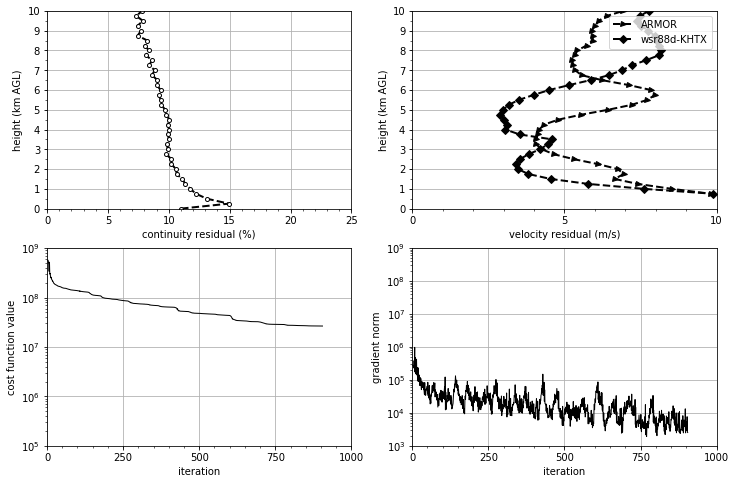

In [29]:
fig = plt.figure(figsize=(12, 8))

# (a) Relative mass continuity residual
axa = fig.add_subplot(221, xlim=(0, 25), ylim=(0, 10))
axa.plot(metric.alpha_profile * 100.0, metric.solver.z / 1000.0, 'k--', lw=2, 
         marker='o', ms=4, mec='k', mfc='w', alpha=None, label='$\alpha$')
axa.xaxis.set_major_locator(MultipleLocator(5))
axa.xaxis.set_minor_locator(MultipleLocator(1))
axa.yaxis.set_major_locator(MultipleLocator(1))
axa.yaxis.set_minor_locator(MultipleLocator(0.5))
axa.set_xlabel('continuity residual (%)')
axa.set_ylabel('height (km AGL)')
axa.grid(which='major')

# (b) Radar observation residual
axb = fig.add_subplot(222, xlim=(0, 10), ylim=(0, 10))
#axb.plot(metric.ARM_SGP_CSAPR['vdop_rmse_profile'], metric.solver.z / 1000.0, 'k--', 
#         lw=2, marker='s', ms=5, mec='k', mfc='w', alpha=None, label='CSAPR')
axb.plot(metric.ARMR['vdop_rmse_profile'], metric.solver.z / 1000.0, 'k--', 
         lw=2, marker='>', ms=5, mec='k', mfc='k', alpha=None, label='ARMOR')
axb.plot(metric.wsr88dKHTX['vdop_rmse_profile'], metric.solver.z / 1000.0, 'k--', 
         lw=2, marker='D', ms=5, mec='k', mfc='k', alpha=None, label='wsr88d-KHTX')
axb.xaxis.set_major_locator(MultipleLocator(5))
axb.xaxis.set_minor_locator(MultipleLocator(1))
axb.yaxis.set_major_locator(MultipleLocator(1))
axb.yaxis.set_minor_locator(MultipleLocator(0.5))
axb.set_xlabel('velocity residual (m/s)')
axb.set_ylabel('height (km AGL)')
axb.legend(loc='upper right')
axb.grid(which='major')

# (c) Cost function value
axc = fig.add_subplot(223, xlim=(0, 1000), ylim=(1.0e5, 1.0e9))
axc.semilogy(metric.cost_iter, metric.cost_value, 'k-', lw=1)
axc.xaxis.set_major_locator(MultipleLocator(250))
axc.xaxis.set_minor_locator(MultipleLocator(50))
axc.set_xlabel('iteration')
axc.set_ylabel('cost function value')
axc.grid(which='major')

# (d) Cost function gradient magnitude
axd = fig.add_subplot(224, xlim=(0, 1000), ylim=(1.0e3, 1.0e9))
axd.semilogy(metric.cost_grad_iter, metric.cost_grad_mag, 'k-', lw=1)
axd.xaxis.set_major_locator(MultipleLocator(250))
axd.xaxis.set_minor_locator(MultipleLocator(50))
axd.set_xlabel('iteration')
axd.set_ylabel('gradient norm')
axd.grid(which='major')

#### Plot wind retrieval results

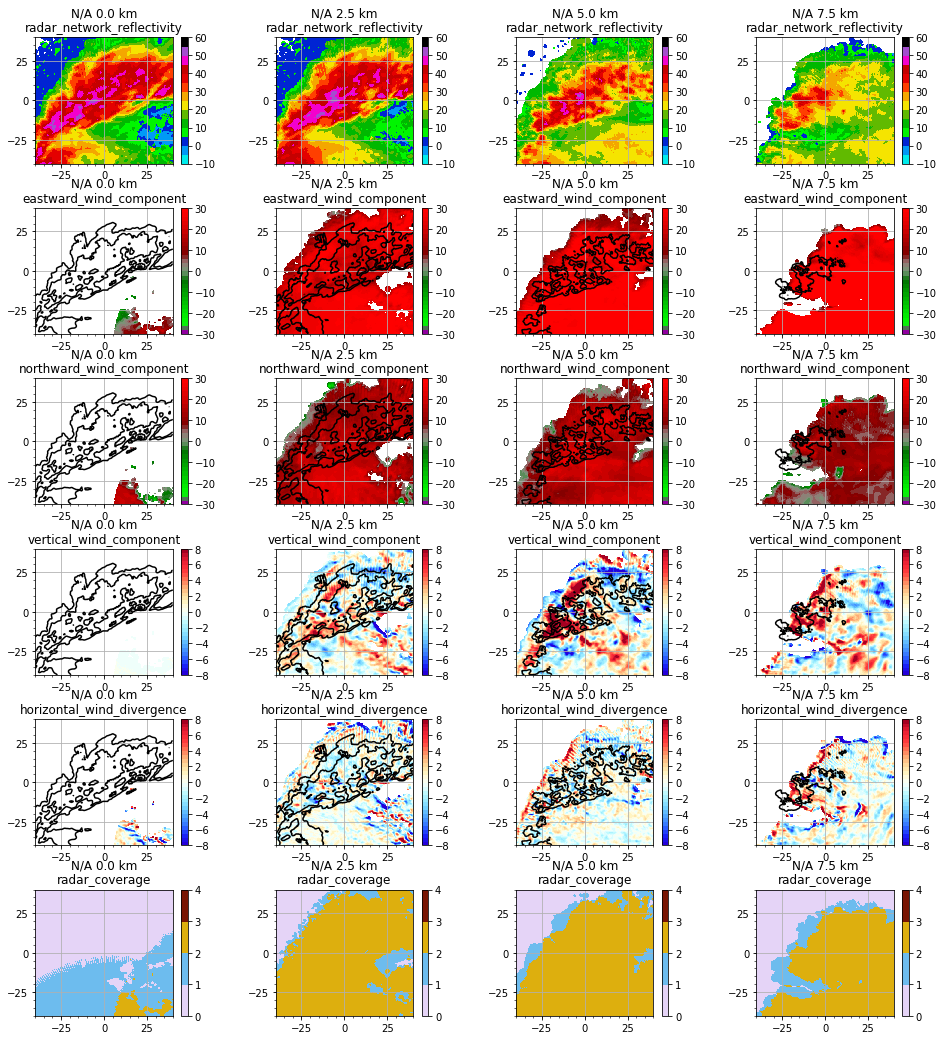

In [37]:
subs = {'xlim': (-40, 40), 'ylim': (-40, 40)}
figs = {'figsize': (16, 18)}
fig, axes = plt.subplots(nrows=6, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.4, hspace=0.35)

heights = [0, 10, 20, 30]

for i, height in enumerate(heights):
    
    # (a) Network reflectivity
    _plot_cappi(conv, 'radar_network_reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Eastward wind component
    _plot_conv(conv, 'eastward_wind_component', height=height, cmap=cmap_uvel, 
                norm=norm_uvel, ticks=ticks_uvel, fig=fig, ax=axes[1,i])
    
    # (c) Northward wind component
    _plot_conv(conv, 'northward_wind_component', height=height, cmap=cmap_vvel, 
                norm=norm_vvel, ticks=ticks_vvel, fig=fig, ax=axes[2,i])
    
    # (d) Vertical wind component
    _plot_conv(conv, 'vertical_wind_component', height=height, cmap=cmap_wvel, 
                norm=norm_wvel, ticks=ticks_wvel, fig=fig, ax=axes[3,i])
    
    # (e) Horizontal wind divergence
    _plot_conv(conv, 'horizontal_wind_divergence', height=height, scale=1.0e3, 
                cmap=cmap_hdiv, norm=norm_hdiv, ticks=ticks_hdiv, fig=fig, 
                ax=axes[4,i])
    
    # (f) Radar coverage
    _plot_cappi(conv, 'radar_coverage', height=height, cmap=cmap_cover, 
                norm=norm_cover, ticks=ticks_cover, fig=fig, ax=axes[5,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(25))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(25))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

### Plot Vertical Cross section

In [58]:
radar=read_grid(filename)

In [80]:
print radar.x['data'][:]

[-40000. -39750. -39500. -39250. -39000. -38750. -38500. -38250. -38000.
 -37750. -37500. -37250. -37000. -36750. -36500. -36250. -36000. -35750.
 -35500. -35250. -35000. -34750. -34500. -34250. -34000. -33750. -33500.
 -33250. -33000. -32750. -32500. -32250. -32000. -31750. -31500. -31250.
 -31000. -30750. -30500. -30250. -30000. -29750. -29500. -29250. -29000.
 -28750. -28500. -28250. -28000. -27750. -27500. -27250. -27000. -26750.
 -26500. -26250. -26000. -25750. -25500. -25250. -25000. -24750. -24500.
 -24250. -24000. -23750. -23500. -23250. -23000. -22750. -22500. -22250.
 -22000. -21750. -21500. -21250. -21000. -20750. -20500. -20250. -20000.
 -19750. -19500. -19250. -19000. -18750. -18500. -18250. -18000. -17750.
 -17500. -17250. -17000. -16750. -16500. -16250. -16000. -15750. -15500.
 -15250. -15000. -14750. -14500. -14250. -14000. -13750. -13500. -13250.
 -13000. -12750. -12500. -12250. -12000. -11750. -11500. -11250. -11000.
 -10750. -10500. -10250. -10000.  -9750.  -9500.  -

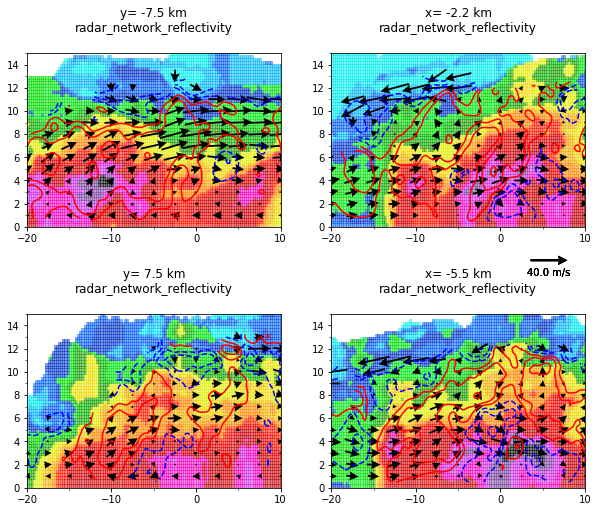

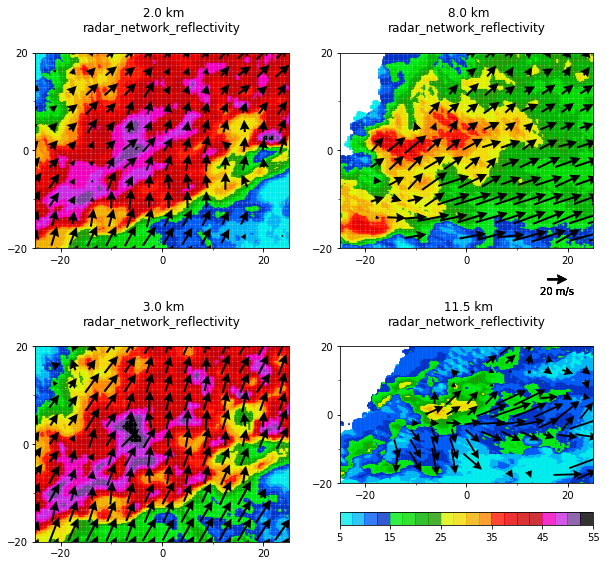

In [114]:
# Normalize colour maps
norm_refl = BoundaryNorm(np.arange(5, 57.5, 2.5), cmap_refl.N)
norm_uvel = BoundaryNorm(np.arange(-30, 32, 2), cmap_uvel.N)
norm_vvel = BoundaryNorm(np.arange(-30, 32, 2), cmap_vvel.N)
norm_wvel = BoundaryNorm(np.arange(-16, 16.5, 0.5), cmap_wvel.N)
norm_hdiv = BoundaryNorm(np.arange(-8, 8.5, 0.5), cmap_hdiv.N)
norm_cover = BoundaryNorm(np.arange(0, 6, 1), cmap_cover.N)
norm_fall = BoundaryNorm(np.arange(0, 8.1, 0.1), cmap_fall.N)

# Define colour bar ticks
ticks_refl = np.arange(5, 70, 10)
ticks_uvel = np.arange(-30, 35, 5)
ticks_vvel = np.arange(-30, 35, 5)
ticks_wvel = np.arange(-16, 20, 4)
ticks_hdiv = np.arange(-8, 10, 2)
ticks_fall = np.arange(0, 9, 1)
ticks_cover = np.arange(0, 6, 1)

## vertical cross sections
U2_field = 'northward_wind_component'
U_field = 'eastward_wind_component'
V_field = 'vertical_wind_component'
skipx = 10; skipy = 4;
storm_u=17
storm_v=7

subs = {'xlim': (-20,10), 'ylim': (0, 15)}
#subs = {'xlim': (-15,15), 'ylim': (0, 2)}
figs = {'figsize': (10, 8)}
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.2, hspace=0.5)
scale=1
#  Reflectivity y slices
xslice=-1; yslice = 130;
_plot_vcappi(radar, 'radar_network_reflectivity', U_field,V_field, xslice=xslice,yslice=yslice, windscale=scale,cmap=cmap_refl, 
            norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,0], alpha=0.5,colbar=False, skip_x=skipx,skip_y=skipy,
            stormu=storm_u)
    
xslice=-1; yslice = 190;
_plot_vcappi(radar, 'radar_network_reflectivity', U_field,V_field,  xslice=xslice,yslice=yslice, windscale=scale,cmap=cmap_refl, 
            norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[1,0], alpha=0.5, colbar=False, skip_x=skipx,skip_y=skipy,
            stormu=storm_u)

#  Reflectivity x slices
xslice=151; yslice = -1;
_plot_vcappi(radar, 'radar_network_reflectivity', U2_field,V_field,  xslice=xslice,yslice=yslice, windscale=scale,cmap=cmap_refl, 
            norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,1], alpha=0.5, colbar=False, skip_x=skipx,skip_y=skipy,
            stormu=storm_v)
    
xslice=138; yslice = -1;
_plot_vcappi(radar, 'radar_network_reflectivity',U2_field,V_field,  xslice=xslice,yslice=yslice, windscale=scale,cmap=cmap_refl, 
            norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[1,1], alpha=0.5, colbar=False, skip_x=skipx,skip_y=skipy,
            stormu=storm_v)


# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    #ax.grid(which='major')

# Save figure
fig.savefig('/data1/moue/fig/mairmorkhtxwind_v_'+armorfile[-17:-9]+'.'+armorfile[-9:-3]+'.png', format='png', dpi=300, 
            bbox_inches='tight', pad_inches=0.5, transparent=False, frameon=True)

### Horizontal plots    
U_field = 'eastward_wind_component'
V_field = 'northward_wind_component'
skipx = 15; skipy = 15;
scale=1

subs = {'xlim': (-25, 25), 'ylim': (-20, 20)}
#subs = {'xlim': (-15, 15), 'ylim': (-15, 15)}
figs = {'figsize': (10, 9)}
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.2, hspace=0.5)

height = 8
_plot_cappi(radar, 'radar_network_reflectivity',  height=height, cmap=cmap_refl, 
            norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,0], alpha=0.7, colbar=False)
_plot_cappi_uv(radar,  U_field,V_field, scale=scale, height=height, fig=fig, ax=axes[0,0],skip_x=skipx,skip_y=skipy)

height = 12
_plot_cappi(radar, 'radar_network_reflectivity',  height=height, cmap=cmap_refl, 
            norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[1,0], alpha=0.7, colbar=False)
_plot_cappi_uv(radar,  U_field,V_field, scale=scale, height=height, fig=fig, ax=axes[1,0],skip_x=skipx,skip_y=skipy)

height = 32
_plot_cappi(radar, 'radar_network_reflectivity',   height=height, cmap=cmap_refl, 
            norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,1], alpha=0.7, colbar=False)
_plot_cappi_uv(radar,  U_field,V_field, scale=scale, height=height, fig=fig, ax=axes[0,1],skip_x=skipx,skip_y=skipy)

height = 46
_plot_cappi(radar, 'radar_network_reflectivity',  height=height, cmap=cmap_refl, 
            norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[1,1], alpha=0.8, colbar=True)
_plot_cappi_uv(radar,  U_field,V_field, scale=scale, height=height, fig=fig, ax=axes[1,1],skip_x=skipx,skip_y=skipy)

   

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    
# Save figure
fig.savefig('/data1/moue/fig/armorkhtxwind_h_'+armorfile[-17:-9]+'.'+armorfile[-9:-3]+'.png', format='png', dpi=300, 
            bbox_inches='tight', pad_inches=0.5, transparent=False, frameon=True)


Wind convergence statistics

In [103]:
# Parse wind divergence data
#div_wrf = radar1.fields['horizontal_wind_divergence']['data']
div_var = conv.fields['horizontal_wind_divergence']['data']
#con_wrf = -1.0e3 * np.ma.masked_greater_equal(div_wrf, 0.0)
con_var = -1.0e3 * np.ma.masked_greater_equal(div_var, 0.0)

# Conditionally sample convergence where column-integrated
# reflectivity is "sufficiently large"
#refl_integrate = radar1.fields['column_integrated_reflectivity']['data']
#con_wrf = np.ma.masked_where(refl_integrate < -40.0, con_wrf)
#con_var = np.ma.masked_where(refl_integrate < -40.0, con_var)
refl = conv.fields['radar_network_reflectivity']['data']
#con_wrf = np.ma.masked_where(refl < -40.0, con_wrf)
con_var = np.ma.masked_where(refl < 10.0, con_var)

# Convert masked elements to NaNs in order to use NumPy percentile
#con_wrf = np.ma.filled(con_wrf, np.nan)
#con_var = np.ma.filled(con_var, np.nan)

# Compute percentiles
percentiles = [50, 90, 95, 99, 100]
#con_pct_wrf = np.nanpercentile(con_wrf, percentiles, axis=(1, 2))
con_pct_var = np.nanpercentile(con_var, percentiles, axis=(1, 2))

Updraft and downdraft velocity statistics

In [104]:
# Parse updraft & downdraft velocity data
#wvel_wrf = radar1.fields['w']['data']
wvel_var = conv.fields['vertical_wind_component']['data']
updraft_var = np.ma.masked_less_equal(wvel_var, 0.0)
downdraft_var = np.ma.abs(np.ma.masked_greater_equal(wvel_var, 0.0))

# Conditionally sample vertical velocities where column-integrated
# reflectivity is "sufficiently large"
refl = conv.fields['radar_network_reflectivity']['data']
updraft_var = np.ma.masked_where(refl < -10.0, updraft_var)
downdraft_var = np.ma.masked_where(refl < -10.0, downdraft_var)

# Convert masked elements to NaNs in order to use NumPy percentile
#updraft_var = np.ma.filled(updraft_var, np.nan)

# Compute percentiles
percentiles = [50, 90, 95, 99, 100]
updraft_pct_var = np.nanpercentile(updraft_var, percentiles, axis=(1, 2))
downdraft_pct_var = np.nanpercentile(downdraft_var, percentiles, axis=(1, 2))

In [23]:
print con_pct_var.shape

(5, 41)


PDFs as a function of height

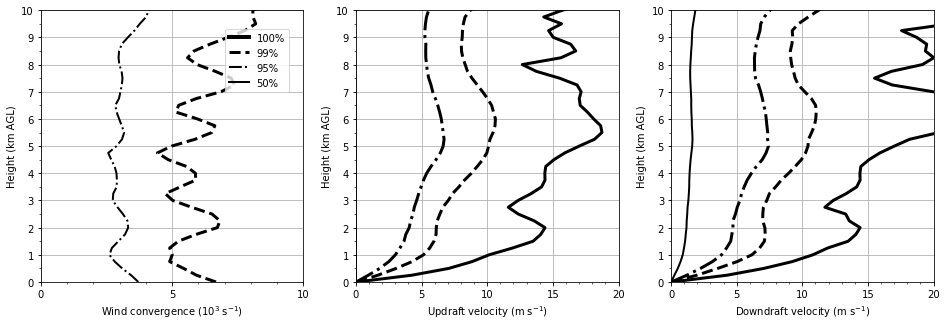

In [105]:
fig = plt.figure(figsize=(16, 5))
axa = fig.add_subplot(131, xlim=(0, 10), ylim=(0, 10))
#axa.plot(metric.alpha_profile * 100.0, metric.solver.z / 1000.0, 'k--', lw=2, 
#         marker='o', ms=4, mec='k', mfc='w', alpha=None, label='$\alpha$')
# (b) 3D-VAR wind convergence percentiles
axa.plot(con_pct_var[4,:], solver.z / 1000.0, 'k-', lw=4, label='100%')
axa.plot(con_pct_var[3,:], solver.z / 1000.0, 'k--', lw=3, label='99%')
axa.plot(con_pct_var[2,:], solver.z / 1000.0, 'k-.', lw=2, label='95%')
axa.plot(con_pct_var[0,:], solver.z / 1000.0, 'k-', lw=2, label='50%')
# Format axes
axa.xaxis.set_major_locator(MultipleLocator(5))
axa.xaxis.set_minor_locator(MultipleLocator(1))
axa.yaxis.set_major_locator(MultipleLocator(1))
axa.yaxis.set_minor_locator(MultipleLocator(0.5))
axa.set_xlabel('Wind convergence (10$^{3}$ s$^{-1}$)')
axa.set_ylabel('Height (km AGL)')
axa.grid(which='major')
axa.legend(loc=[0.7, 0.7])

axb = fig.add_subplot(132, xlim=(0, 20), ylim=(0, 10))
# (b) 3D-VAR updraft velocity percentiles
axb.plot(updraft_pct_var[4,:], solver.z / 1000.0, 'k-', lw=3)
axb.plot(updraft_pct_var[3,:], solver.z / 1000.0, 'k--', lw=3)
axb.plot(updraft_pct_var[2,:], solver.z / 1000.0, 'k-.', lw=3)
axb.plot(updraft_pct_var[0,:], solver.z / 1000.0, 'k-', lw=2)
# Format axes
axb.xaxis.set_major_locator(MultipleLocator(5))
axb.xaxis.set_minor_locator(MultipleLocator(1))
axb.yaxis.set_major_locator(MultipleLocator(1))
axb.yaxis.set_minor_locator(MultipleLocator(0.5))
axb.set_xlabel('Updraft velocity (m s$^{-1}$)')
axb.set_ylabel('Height (km AGL)')
axb.grid(which='major')

axc = fig.add_subplot(133, xlim=(0, 20), ylim=(0, 10))
# (b) 3D-VAR downdraft velocity percentiles
axc.plot(downdraft_pct_var[4,:], solver.z / 1000.0, 'k-', lw=3)
axc.plot(downdraft_pct_var[3,:], solver.z / 1000.0, 'k--', lw=3)
axc.plot(downdraft_pct_var[2,:], solver.z / 1000.0, 'k-.', lw=3)
axc.plot(downdraft_pct_var[0,:], solver.z / 1000.0, 'k-', lw=2)
# Format axes
axc.xaxis.set_major_locator(MultipleLocator(5))
axc.xaxis.set_minor_locator(MultipleLocator(1))
axc.yaxis.set_major_locator(MultipleLocator(1))
axc.yaxis.set_minor_locator(MultipleLocator(0.5))
axc.set_xlabel('Downdraft velocity (m s$^{-1}$)')
axc.set_ylabel('Height (km AGL)')
axc.grid(which='major')
